In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import pickle
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
os.listdir('../input/lish-moa')

['sample_submission.csv',
 'train_drug.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv',
 'train_features.csv',
 'test_features.csv']

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
train_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371


In [5]:
train_targets_scored.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_targets_nonscored.head(2)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.151,-0.775
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.381,-0.730


In [8]:
sample_submission.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASSED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## preprocess data

In [10]:
def drop_ctl_vehicle(train_features, test_features):
    
    train_features = train_features[train_features['cp_type'] != 'ctl_vehicle']
    test_features = test_features[test_features['cp_type'] != 'ctl_vehicle']
    target = train_targets_scored.iloc[train_features.index]
    train_features.reset_index(drop=True, inplace=True)
    test_features.reset_index(drop=True, inplace=True)
    
    return train_features, test_features, target

# train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
# test_features

In [11]:
def rank_gauss(train_features, test_features):
    
    train_features_ = train_features.copy()
    test_features_ = test_features.copy()
    
    GENES = [col for col in train_features_.columns if col.startswith('g-')]
    CELLS = [col for col in train_features_.columns if col.startswith('c-')]
    
    for col in (GENES + CELLS):

        transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
        vec_len = len(train_features_[col].values)
        vec_len_test = len(test_features_[col].values)
        raw_vec = train_features_[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)

        train_features_[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
        test_features_[col] = transformer.transform(test_features_[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
        
    return train_features_, test_features_

# train_features1, test_features1 = rank_gauss(train_features, test_features)
# train_features1

In [12]:
def get_stats(train_features, test_features):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    for df in [train_features, test_features]:
#         df['g_sum'] = df[GENES].sum(axis = 1)
        df['g_mean'] = df[GENES].mean(axis = 1)
        df['g_std'] = df[GENES].std(axis = 1)
        df['g_kurt'] = df[GENES].kurtosis(axis = 1)
        df['g_skew'] = df[GENES].skew(axis = 1)
#         df['g_max'] = df[GENES].max(axis=1)
#         df['g_min'] = df[GENES].max(axis=1)
#         df['c_sum'] = df[CELLS].sum(axis=1)
        df['c_mean'] = df[CELLS].mean(axis = 1)
        df['c_std'] = df[CELLS].std(axis = 1)
        df['c_kurt'] = df[CELLS].kurtosis(axis = 1)
        df['c_skew'] = df[CELLS].skew(axis = 1)
#         df['c_max'] = df[CELLS].max(axis=1)
#         df['c_min'] = df[CELLS].min(axis=1)
#         df['gc_sum'] = df[GENES + CELLS].sum(axis = 1)
        df['gc_mean'] = df[GENES + CELLS].mean(axis = 1)
        df['gc_std'] = df[GENES + CELLS].std(axis = 1)
        df['gc_kurt'] = df[GENES + CELLS].kurtosis(axis = 1)
        df['gc_skew'] = df[GENES + CELLS].skew(axis = 1)
        
    return train_features, test_features

# train_features, test_features = get_stats(train_features, test_features)
# test_features

In [13]:
def get_pca(train_features, test_features, n_gs, n_cs):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    pca_gs = PCA(n_components = n_gs)
    pca_cs = PCA(n_components = n_cs)
    
    train_pca_gs = pca_gs.fit_transform(train_features[GENES])
    train_pca_cs = pca_cs.fit_transform(train_features[CELLS])
    test_pca_gs = pca_gs.transform(test_features[GENES])
    test_pca_cs = pca_cs.transform(test_features[CELLS])
    
    train_pca_gs = pd.DataFrame(train_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    train_pca_cs = pd.DataFrame(train_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    test_pca_gs = pd.DataFrame(test_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    test_pca_cs = pd.DataFrame(test_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    
    train_features = pd.concat([train_features, train_pca_gs, train_pca_cs], axis=1)
    test_features = pd.concat([test_features, test_pca_gs, test_pca_cs], axis=1)
    
    return train_features, test_features

# train_features, test_features = get_pca(train_features, test_features, n_gs=50, n_cs=15)
# test_features

In [14]:
def var_thresh(threshold, train_features, test_features):

    cols_numeric = [f for f in train_features.columns if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
    mask = (train_features[cols_numeric].var() >= 0.8).values
    train_features_ = train_features[cols_numeric].loc[:, mask]
    test_features_ = test_features[cols_numeric].loc[:, mask]
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1).reset_index(drop=True)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1).reset_index(drop=True)

    return train_features, test_features

# train_features, test_features = var_thresh_2(threshold=0.2, train_features=train_features, test_features=test_features)
# test_features

In [15]:
def get_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 0):
    
    GENES = [col for col in train.columns if col.startswith('g-')]
    CELLS = [col for col in train.columns if col.startswith('c-')]
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        
        return train, test
    
    train, test = create_cluster(train, test, GENES, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, CELLS, kind = 'c', n_clusters = n_clusters_c)
    
    return train, test

# train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)

In [16]:
def scaling(train_features, test_features):
    
    scaler = RobustScaler()
    train_features_ = train_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1)
    columns_ = train_features_.columns
    train_features_numerical = scaler.fit_transform(train_features_)
    test_features_numerical = scaler.transform(test_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1))
    train_features_ = pd.DataFrame(train_features_numerical)
    test_features_ = pd.DataFrame(test_features_numerical)
    train_features_ = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1)
    test_features_ = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1)
    
    return train_features_, test_features_

# train_features, test_features = scaling2(train_features, test_features)
# test_features

In [17]:
def make_folds(train, num_starts, num_splits):
    
    train_ = train.copy()
    folds = []

    # LOAD FILES
    train_feats = pd.read_csv('../input/lish-moa/train_features.csv')
    scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
    scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
    drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left') 

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[(vc <= 6) | (vc == 12) | (vc == 18)].index.sort_values()
    vc2 = vc.loc[(vc > 6) & (vc != 12) & (vc != 18)].index.sort_values()

    for seed in range(num_starts):

        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}; dct2 = {}
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        scored['fold'] = scored.drug_id.map(dct1)
        scored.loc[scored.fold.isna(),'fold'] =\
            scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
        scored.fold = scored.fold.astype('int8')
        folds.append(scored.fold.values)

        del scored['fold']
        
        for i in range(len(folds)):
            train_[f'seed{i}'] = folds[i]

    return train_

In [18]:
def make_folds_old(train, n_splits):
    
    folds = train.copy()

    mskf = MultilabelStratifiedKFold(n_splits)

    for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
        folds.loc[v_idx, 'kfold'] = int(f)

    folds['kfold'] = folds['kfold'].astype(int)
    
    return folds

In [19]:
def preprocessor(train_features, test_features):
    
    print('preprocess start')
    
#     # drop_ctl_vehicle
#     train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
    
    # rank_gauss
    train_features, test_features = rank_gauss(train_features, test_features)
    print('rank_gauss: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # stats
    train_features, test_features = get_stats(train_features, test_features)
    print('get_stats: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # pca
    train_features, test_features = get_pca(train_features, test_features, n_gs=600, n_cs=50) 
    print('get_pca: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # var_thresh
    train_features, test_features = var_thresh(threshold=0.8, train_features=train_features, test_features=test_features)
    print('var_thresh: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
#     # clustering
#     train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)
#     print('clustering: done')
#     print('train_features.shape', train_features.shape)
#     print('test_features.shape', test_features.shape)
    
#     # Scaling
#     train_features, test_features = scaling(train_features, test_features)
#     print('scaling: done')
    
    # data merge
    train = train_features.merge(train_targets_scored, on='sig_id').merge(train_targets_nonscored, on ='sig_id')
    train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
    test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

    target = train[train_targets_scored.columns]
    target_nonscored = train[train_targets_nonscored.columns]
    
    train = train.drop('cp_type', axis=1)
    test = test.drop('cp_type', axis=1)
    
    return train, target, test, target_nonscored  

train, target, test, target_nonscored = preprocessor(train_features, test_features)

preprocess start
rank_gauss: done
train_features.shape (23814, 876)
test_features.shape (3982, 876)
get_stats: done
train_features.shape (23814, 888)
test_features.shape (3982, 888)
get_pca: done
train_features.shape (23814, 1538)
test_features.shape (3982, 1538)
var_thresh: done
train_features.shape (23814, 1044)
test_features.shape (3982, 1044)


In [20]:
folds = make_folds_old(train, n_splits=5)

In [21]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target_nonscored_cols = target_nonscored.drop('sig_id', axis=1).columns.values.tolist()
feature_cols = [c for c in pd.get_dummies(train, columns=['cp_time', 'cp_dose']).columns if (c not in target_cols) & (c not in target_nonscored_cols)]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id']]
all_target_cols = target_cols + target_nonscored_cols

num_features = len(feature_cols)
num_targets = len(target_cols)
num_targets_nonscored = len(target_nonscored_cols)
num_all_targets = len(all_target_cols)

print(f'num_features: {num_features}')
print(f'num_targets: {num_targets}')
print(f'num_targets_nonscored: {num_targets_nonscored}')
print(f'num_all_targets: {num_all_targets}')

num_features: 1045
num_targets: 206
num_targets_nonscored: 402
num_all_targets: 608


### shape check

In [22]:
print(f'train.shape: {train.shape}')
print(f'folds.shape: {folds.shape}')
print(f'test.shape: {test.shape}')
print(f'target.shape: {target.shape}')
print(f'target_nonscored.shape: {target_nonscored.shape}')
print(f'sample_submission.shape: {sample_submission.shape}')

train.shape: (21948, 1651)
folds.shape: (21948, 1652)
test.shape: (3624, 1043)
target.shape: (21948, 207)
target_nonscored.shape: (21948, 403)
sample_submission.shape: (3982, 207)


In [23]:
all_data = {
    'train': train, 
    'folds': folds, 
    'test': test, 
    'target': target, 
    'target_nonscored': target_nonscored, 
    'sample_submission': sample_submission
}

In [24]:
with open('all_data_Simple_Deep.pickle', 'wb') as f:
    pickle.dump(all_data, f)

## Dataset Classes

In [25]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float), 
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

### HyperParameters

In [26]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 24
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NFOLDS = 5

smoothing = 0.001
p_min = smoothing
p_max = 1 - smoothing

WEIGHT_DECAY = {'ALL_TARGETS': 1e-5, 'SCORED_ONLY': 3e-6}
MAX_LR = {'ALL_TARGETS': 1e-2, 'SCORED_ONLY': 3e-3}
DIV_FACTOR = {'ALL_TARGETS': 1e3, 'SCORED_ONLY': 1e2}
PCT_START = 0.1

### Model

In [27]:
class Model_Simple_Deep(nn.Module):
    
    def __init__(self, num_features, num_targets):
        
        super(Model_Simple_Deep, self).__init__()
        self.hidden_size = [1500, 1250, 1000, 750]
        self.dropout_value = [0.5, 0.35, 0.3, 0.25]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))

        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x
    
class LabelSmoothingLoss(nn.Module):
    
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))    

In [28]:
class FineTuneScheduler:
    def __init__(self, epochs):
        self.epochs = epochs
        self.epochs_per_step = 0
        self.frozen_layers = []
        
    def copy_without_top(self, model, num_features, num_targets, num_targets_new):
        self.frozen_layers = []
        
        model_new = Model_Simple_Deep(num_features, num_targets)
        model_new.load_state_dict(model.state_dict())
        
        # Freeze all weights
        for name, param in model_new.named_parameters():
            layer_index = name.split('.')[0][-1]
            
            if layer_index == 5:
                continue
                
            param.requires_grad = False
            
            # Save frozen layer names
            if layer_index not in self.frozen_layers:
                self.frozen_layers.append(layer_index)
                
        self.epochs_per_step = self.epochs // len(self.frozen_layers)
        
        # Replace the top layers with another ones
        model_new.batch_norm5 = nn.BatchNorm1d(model_new.hidden_size[3])
        model_new.dropout5 = nn.Dropout(model_new.dropout_value[3])
        model_new.dense5 = nn.utils.weight_norm(nn.Linear(model_new.hidden_size[-1], num_targets_new))
        model_new.to(DEVICE)
        return model_new
    
    def step(self, epoch, model):
        if len(self.frozen_layers) == 0:
            return 
        
        if epoch % self.epochs_per_step == 0:
            last_frozen_index = self.frozen_layers[-1]
            
            # Unfreeze parameters of the last frozen layer
            for name, param in model.named_parameters():
                layer_index = name.split('.')[0][-1]
                
                if layer_index == last_frozen_index:
                    param.requires_grad = True
                    
            del self.frozen_layers[-1]  # Remove the last layer as unfrozen

### training function

In [29]:
def train_fn(model, optimizer, scheduler, loss_tr, loss_fn, dataloader, device):
    rejected = 0
    model.train()
    final_loss = 0
    final_metric = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        if len(inputs) > 1:
            outputs = model(inputs)
            loss = loss_tr(outputs, targets)
            metric = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            final_loss += loss.item()
            final_metric += metric.item()
        
        else:
            print('rejected')
            rejected += len(inputs)
            
        
    final_loss /= (len(dataloader) - rejected)
    final_metric /= (len(dataloader) - rejected)
    
    return final_loss, final_metric

In [30]:
def valid_fn(model, loss_tr, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    final_metric = 0
    valid_preds = []
    
    for data in dataloader:
        
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_tr(outputs, targets)
        metric = loss_fn(outputs, targets)
        final_loss += loss.item()
        final_metric += metric.item()
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)
        valid_preds.append(outputs.numpy())
        
    final_loss /= len(dataloader)
    final_metric /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
        
    return final_loss, final_metric, valid_preds

In [31]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)    
        preds.append(outputs.numpy())
        
    preds = np.concatenate(preds)
        
    return preds

### loss_function

In [32]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets, n_classes, smoothing=0.0):
        assert 0 <= smoothing <= 1
        with torch.no_grad():
            targets = targets * (1 - smoothing) + torch.ones_like(targets).to(DEVICE) * smoothing / n_classes
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss()._smooth(targets, inputs.shape[1], self.smoothing)

        if self.weight is not None:
            inputs = inputs * self.weight.unsqueeze(0)

        loss = F.binary_cross_entropy_with_logits(inputs, targets)

        return loss

In [33]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets
    
    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

### Single fold training

In [34]:
def run_training(fold, seed, EPOCHS, LEARNING_RATE):
    
    print(f'==========FOLD{fold+1}==========')
    
    
    seed_everything(seed)
    
    train_losses = list()
    valid_losses = list()
    CV = list()
    
    train = pd.get_dummies(folds, columns=['cp_time', 'cp_dose'])
    test_ = pd.get_dummies(test, columns=['cp_time', 'cp_dose'])
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index()
    valid_df = train[train['kfold'] == fold].reset_index()
    
    def train_model(model, tag_name, target_cols_now, fine_tune_scheduler=None):
        
        print(f'=={tag_name}==')
        
        train_losses = list()
        valid_losses = list()
        
        x_train, y_train  = train_df[feature_cols].values, train_df[target_cols_now].values
        x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols_now].values
        
        train_dataset = MoADataset(x_train, y_train)
        valid_dataset = MoADataset(x_valid, y_valid)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY[tag_name])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  steps_per_epoch=len(trainloader),
                                                  pct_start=PCT_START,
                                                  div_factor=DIV_FACTOR[tag_name], 
                                                  max_lr=MAX_LR[tag_name],
                                                  epochs=EPOCHS)
        
        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing=smoothing)

        oof = np.zeros((len(train), len(target_cols_now)))
        best_loss = np.inf

        for epoch in range(EPOCHS):
        
            if fine_tune_scheduler is not None:
                fine_tune_scheduler.step(epoch, model)
        
            print(f'-----EPOCH{epoch+1}-----')

            train_loss, train_metric = train_fn(model, optimizer, scheduler, loss_tr, loss_fn, trainloader, DEVICE)
            print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
            train_losses.append(train_loss)
            valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader, DEVICE)
            print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
            valid_losses.append(valid_loss)

            if valid_loss < best_loss:

                best_loss = valid_loss
                oof[val_idx] = valid_preds
                torch.save(model.state_dict(), f'Simple_Deep_FOLD{fold+1}_SEED{seed}.pth')

        plt.plot(train_losses, label='train_losses')
        plt.plot(valid_losses, label='valid_losses')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        if tag_name == 'ALL_TARGETS':
            plt.ylim([6e-3, 1.5e-2])
        else:
            plt.ylim([1e-2, 2e-2])
        plt.title(f'fold{fold+1} losses')
        plt.show()

        return oof
    
    fine_tune_scheduler = FineTuneScheduler(EPOCHS)
    
    pretrained_model = Model_Simple_Deep(num_features, num_all_targets)
    pretrained_model.to(DEVICE)
    
    # Train on scored + nonscored targets
    train_model(pretrained_model, 'ALL_TARGETS', all_target_cols)
    
    # Load the pretrained model with the best loss
    pretrained_model = Model_Simple_Deep(num_features, num_all_targets)
    pretrained_model.load_state_dict(torch.load(f'Simple_Deep_FOLD{fold+1}_SEED{seed}.pth'))
    pretrained_model.to(DEVICE)
    
    # Copy model without the top layer)
    final_model = fine_tune_scheduler.copy_without_top(pretrained_model, num_features, num_all_targets, num_targets)
    
    # Fine-ture the model on scored targets only
    oof = train_model(final_model, 'SCORED_ONLY', target_cols, fine_tune_scheduler)
    
    #-----------------------PREDICTION-------------------------
                
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load the fine tuned model with the best loss
    model = Model_Simple_Deep(num_features, num_targets)
    model.load_state_dict(torch.load(f'Simple_Deep_FOLD{fold+1}_SEED{seed}.pth'))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [35]:
def run_k_fold(NFOLD, seed, EPOCH, LEARNING_RATE):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed, EPOCH, LEARNING_RATE)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

device used: cuda
 
SEED : 0

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50916, train_metric: 0.50873
valid_loss: 0.03093, valid_metric: 0.02879
-----EPOCH2-----
train_loss: 0.01576, train_metric: 0.01293
valid_loss: 0.01453, valid_metric: 0.01143
-----EPOCH3-----
train_loss: 0.01391, train_metric: 0.01066
valid_loss: 0.01437, valid_metric: 0.01061
-----EPOCH4-----
train_loss: 0.01304, train_metric: 0.00961
valid_loss: 0.01271, valid_metric: 0.00944
-----EPOCH5-----
train_loss: 0.01296, train_metric: 0.00964
valid_loss: 0.01652, valid_metric: 0.01317
-----EPOCH6-----
train_loss: 0.01297, train_metric: 0.00967
valid_loss: 0.01286, valid_metric: 0.00965
-----EPOCH7-----
train_loss: 0.01287, train_metric: 0.00960
valid_loss: 0.01267, valid_metric: 0.00941
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00960
valid_loss: 0.01287, valid_metric: 0.00967
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00957
valid_loss: 0.01273, valid_metric: 0.00948
-

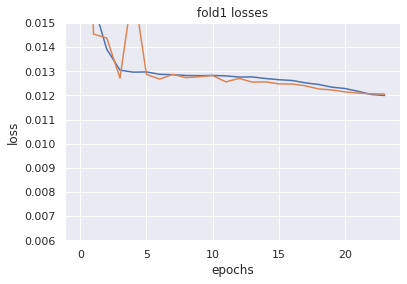

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65372, train_metric: 0.65365
valid_loss: 0.30551, valid_metric: 0.30499
-----EPOCH2-----
train_loss: 0.06687, train_metric: 0.06508
valid_loss: 0.02262, valid_metric: 0.02015
-----EPOCH3-----
train_loss: 0.02111, train_metric: 0.01840
valid_loss: 0.02027, valid_metric: 0.01738
-----EPOCH4-----
train_loss: 0.02008, train_metric: 0.01710
valid_loss: 0.01997, valid_metric: 0.01692
-----EPOCH5-----
train_loss: 0.02292, train_metric: 0.01968
valid_loss: 0.02008, valid_metric: 0.01674
-----EPOCH6-----
train_loss: 0.01979, train_metric: 0.01654
valid_loss: 0.01999, valid_metric: 0.01664
-----EPOCH7-----
train_loss: 0.01961, train_metric: 0.01636
valid_loss: 0.01983, valid_metric: 0.01654
-----EPOCH8-----
train_loss: 0.01952, train_metric: 0.01628
valid_loss: 0.01984, valid_metric: 0.01651
-----EPOCH9-----
train_loss: 0.01976, train_metric: 0.01652
valid_loss: 0.01984, valid_metric: 0.01651
-----EPOCH10-----
train_loss: 0.01947, train_metric: 0.01

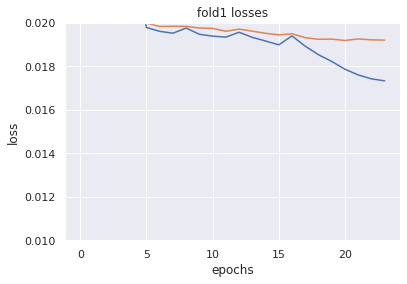

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50906, train_metric: 0.50863
valid_loss: 0.02557, valid_metric: 0.02337
-----EPOCH2-----
train_loss: 0.01585, train_metric: 0.01301
valid_loss: 0.01389, valid_metric: 0.01086
-----EPOCH3-----
train_loss: 0.01335, train_metric: 0.01011
valid_loss: 0.01305, valid_metric: 0.00982
-----EPOCH4-----
train_loss: 0.01294, train_metric: 0.00966
valid_loss: 0.01305, valid_metric: 0.00978
-----EPOCH5-----
train_loss: 0.01293, train_metric: 0.00960
valid_loss: 0.01269, valid_metric: 0.00940
-----EPOCH6-----
train_loss: 0.01277, train_metric: 0.00948
valid_loss: 0.01335, valid_metric: 0.01006
-----EPOCH7-----
train_loss: 0.01282, train_metric: 0.00956
valid_loss: 0.01282, valid_metric: 0.00956
-----EPOCH8-----
train_loss: 0.01280, train_metric: 0.00955
valid_loss: 0.01297, valid_metric: 0.00967
-----EPOCH9-----
train_loss: 0.01281, train_metric: 0.00956
valid_loss: 0.01318, valid_metric: 0.00986
-----EPOCH10-----
train_loss: 0

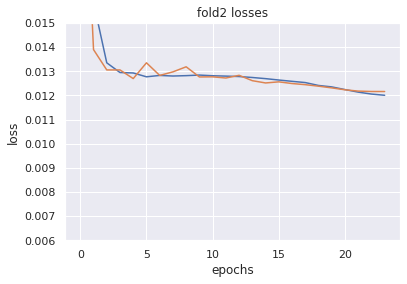

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65054, train_metric: 0.65047
valid_loss: 0.30174, valid_metric: 0.30121
-----EPOCH2-----
train_loss: 0.06628, train_metric: 0.06450
valid_loss: 0.02254, valid_metric: 0.02008
-----EPOCH3-----
train_loss: 0.02114, train_metric: 0.01842
valid_loss: 0.02025, valid_metric: 0.01739
-----EPOCH4-----
train_loss: 0.02002, train_metric: 0.01704
valid_loss: 0.01988, valid_metric: 0.01686
-----EPOCH5-----
train_loss: 0.02164, train_metric: 0.01850
valid_loss: 0.01989, valid_metric: 0.01662
-----EPOCH6-----
train_loss: 0.01980, train_metric: 0.01660
valid_loss: 0.01978, valid_metric: 0.01655
-----EPOCH7-----
train_loss: 0.01969, train_metric: 0.01647
valid_loss: 0.01975, valid_metric: 0.01646
-----EPOCH8-----
train_loss: 0.01960, train_metric: 0.01637
valid_loss: 0.01974, valid_metric: 0.01655
-----EPOCH9-----
train_loss: 0.01996, train_metric: 0.01672
valid_loss: 0.01977, valid_metric: 0.01658
-----EPOCH10-----
train_loss: 0.01954, train_metric: 0.01

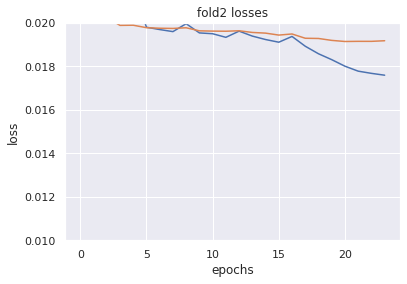

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51082, train_metric: 0.51039
valid_loss: 0.02669, valid_metric: 0.02459
-----EPOCH2-----
train_loss: 0.01623, train_metric: 0.01338
valid_loss: 0.01398, valid_metric: 0.01079
-----EPOCH3-----
train_loss: 0.01358, train_metric: 0.01031
valid_loss: 0.01676, valid_metric: 0.01358
-----EPOCH4-----
train_loss: 0.01308, train_metric: 0.00974
valid_loss: 0.01283, valid_metric: 0.00956
-----EPOCH5-----
train_loss: 0.01289, train_metric: 0.00959
valid_loss: 0.01290, valid_metric: 0.00963
-----EPOCH6-----
train_loss: 0.01295, train_metric: 0.00965
valid_loss: 0.01291, valid_metric: 0.00961
-----EPOCH7-----
train_loss: 0.01288, train_metric: 0.00960
valid_loss: 0.01319, valid_metric: 0.00995
-----EPOCH8-----
train_loss: 0.01291, train_metric: 0.00964
valid_loss: 0.01282, valid_metric: 0.00957
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00959
valid_loss: 0.01274, valid_metric: 0.00949
-----EPOCH10-----
train_loss: 0

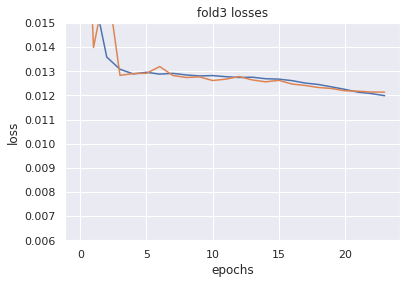

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65264, train_metric: 0.65257
valid_loss: 0.30616, valid_metric: 0.30564
-----EPOCH2-----
train_loss: 0.06695, train_metric: 0.06517
valid_loss: 0.02246, valid_metric: 0.01998
-----EPOCH3-----
train_loss: 0.02118, train_metric: 0.01846
valid_loss: 0.02030, valid_metric: 0.01741
-----EPOCH4-----
train_loss: 0.02003, train_metric: 0.01705
valid_loss: 0.02005, valid_metric: 0.01702
-----EPOCH5-----
train_loss: 0.02388, train_metric: 0.02077
valid_loss: 0.02012, valid_metric: 0.01687
-----EPOCH6-----
train_loss: 0.01980, train_metric: 0.01661
valid_loss: 0.02003, valid_metric: 0.01686
-----EPOCH7-----
train_loss: 0.01965, train_metric: 0.01644
valid_loss: 0.01990, valid_metric: 0.01662
-----EPOCH8-----
train_loss: 0.01958, train_metric: 0.01634
valid_loss: 0.01986, valid_metric: 0.01655
-----EPOCH9-----
train_loss: 0.01978, train_metric: 0.01654
valid_loss: 0.01997, valid_metric: 0.01677
-----EPOCH10-----
train_loss: 0.01947, train_metric: 0.01

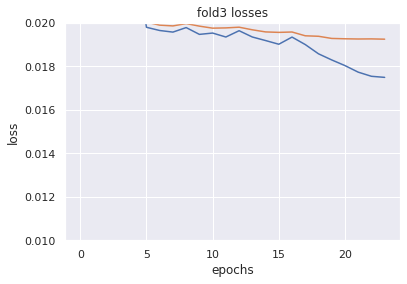

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50722, train_metric: 0.50679
valid_loss: 0.02549, valid_metric: 0.02332
-----EPOCH2-----
train_loss: 0.01583, train_metric: 0.01299
valid_loss: 0.01385, valid_metric: 0.01073
-----EPOCH3-----
train_loss: 0.01340, train_metric: 0.01019
valid_loss: 0.01358, valid_metric: 0.01036
-----EPOCH4-----
train_loss: 0.01310, train_metric: 0.00983
valid_loss: 0.01342, valid_metric: 0.01009
-----EPOCH5-----
train_loss: 0.01350, train_metric: 0.01019
valid_loss: 0.01335, valid_metric: 0.00968
-----EPOCH6-----
train_loss: 0.01308, train_metric: 0.00970
valid_loss: 0.01276, valid_metric: 0.00951
-----EPOCH7-----
train_loss: 0.01292, train_metric: 0.00964
valid_loss: 0.01287, valid_metric: 0.00961
-----EPOCH8-----
train_loss: 0.01290, train_metric: 0.00965
valid_loss: 0.01306, valid_metric: 0.00982
-----EPOCH9-----
train_loss: 0.01288, train_metric: 0.00963
valid_loss: 0.01270, valid_metric: 0.00943
-----EPOCH10-----
train_loss: 0

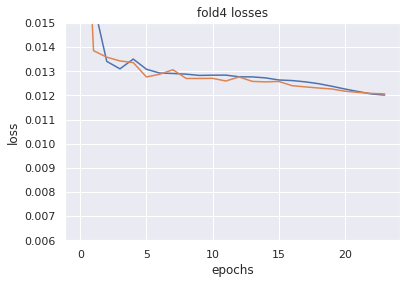

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65065, train_metric: 0.65057
valid_loss: 0.29954, valid_metric: 0.29900
-----EPOCH2-----
train_loss: 0.06602, train_metric: 0.06423
valid_loss: 0.02247, valid_metric: 0.02000
-----EPOCH3-----
train_loss: 0.02118, train_metric: 0.01847
valid_loss: 0.02022, valid_metric: 0.01734
-----EPOCH4-----
train_loss: 0.02003, train_metric: 0.01705
valid_loss: 0.01992, valid_metric: 0.01687
-----EPOCH5-----
train_loss: 0.02538, train_metric: 0.02223
valid_loss: 0.02004, valid_metric: 0.01684
-----EPOCH6-----
train_loss: 0.01976, train_metric: 0.01655
valid_loss: 0.01990, valid_metric: 0.01661
-----EPOCH7-----
train_loss: 0.01965, train_metric: 0.01641
valid_loss: 0.01981, valid_metric: 0.01652
-----EPOCH8-----
train_loss: 0.01956, train_metric: 0.01632
valid_loss: 0.01968, valid_metric: 0.01645
-----EPOCH9-----
train_loss: 0.01970, train_metric: 0.01645
valid_loss: 0.01992, valid_metric: 0.01655
-----EPOCH10-----
train_loss: 0.01956, train_metric: 0.01

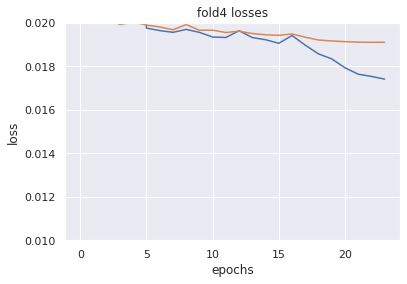

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50851, train_metric: 0.50808
valid_loss: 0.02430, valid_metric: 0.02211
-----EPOCH2-----
train_loss: 0.01615, train_metric: 0.01330
valid_loss: 0.01344, valid_metric: 0.01035
-----EPOCH3-----
train_loss: 0.01331, train_metric: 0.01009
valid_loss: 0.01383, valid_metric: 0.01057
-----EPOCH4-----
train_loss: 0.01366, train_metric: 0.01036
valid_loss: 0.01378, valid_metric: 0.01018
-----EPOCH5-----
train_loss: 0.01335, train_metric: 0.00999
valid_loss: 0.01416, valid_metric: 0.01088
-----EPOCH6-----
train_loss: 0.01311, train_metric: 0.00980
valid_loss: 0.01375, valid_metric: 0.01048
-----EPOCH7-----
train_loss: 0.01306, train_metric: 0.00979
valid_loss: 0.01280, valid_metric: 0.00954
-----EPOCH8-----
train_loss: 0.01305, train_metric: 0.00978
valid_loss: 0.01278, valid_metric: 0.00951
-----EPOCH9-----
train_loss: 0.01293, train_metric: 0.00968
valid_loss: 0.01274, valid_metric: 0.00947
-----EPOCH10-----
train_loss: 0

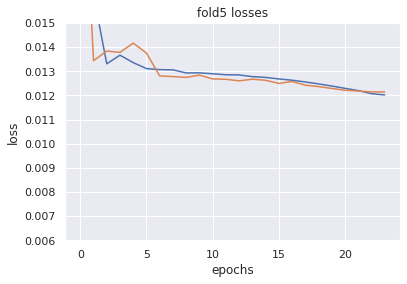

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65232, train_metric: 0.65225
valid_loss: 0.30497, valid_metric: 0.30444
-----EPOCH2-----
train_loss: 0.06652, train_metric: 0.06473
valid_loss: 0.02283, valid_metric: 0.02038
-----EPOCH3-----
train_loss: 0.02119, train_metric: 0.01848
valid_loss: 0.02046, valid_metric: 0.01760
-----EPOCH4-----
train_loss: 0.02003, train_metric: 0.01706
valid_loss: 0.02017, valid_metric: 0.01715
-----EPOCH5-----
train_loss: 0.02188, train_metric: 0.01871
valid_loss: 0.02019, valid_metric: 0.01697
-----EPOCH6-----
train_loss: 0.01973, train_metric: 0.01653
valid_loss: 0.02014, valid_metric: 0.01690
-----EPOCH7-----
train_loss: 0.01969, train_metric: 0.01647
valid_loss: 0.02017, valid_metric: 0.01687
-----EPOCH8-----
train_loss: 0.01957, train_metric: 0.01634
valid_loss: 0.02001, valid_metric: 0.01679
-----EPOCH9-----
train_loss: 0.01975, train_metric: 0.01653
valid_loss: 0.02011, valid_metric: 0.01692
-----EPOCH10-----
train_loss: 0.01961, train_metric: 0.01

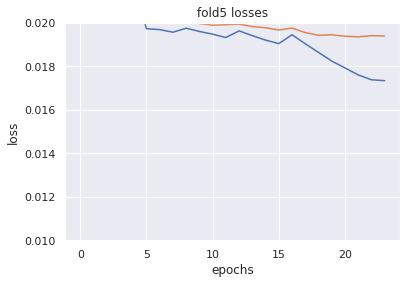

 
SEED : 1

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50840, train_metric: 0.50797
valid_loss: 0.02702, valid_metric: 0.02486
-----EPOCH2-----
train_loss: 0.01582, train_metric: 0.01298
valid_loss: 0.01375, valid_metric: 0.01066
-----EPOCH3-----
train_loss: 0.01337, train_metric: 0.01014
valid_loss: 0.01323, valid_metric: 0.00998
-----EPOCH4-----
train_loss: 0.01292, train_metric: 0.00964
valid_loss: 0.01352, valid_metric: 0.01028
-----EPOCH5-----
train_loss: 0.01305, train_metric: 0.00975
valid_loss: 0.01276, valid_metric: 0.00944
-----EPOCH6-----
train_loss: 0.01295, train_metric: 0.00965
valid_loss: 0.01281, valid_metric: 0.00954
-----EPOCH7-----
train_loss: 0.01299, train_metric: 0.00972
valid_loss: 0.01305, valid_metric: 0.00975
-----EPOCH8-----
train_loss: 0.01288, train_metric: 0.00962
valid_loss: 0.01271, valid_metric: 0.00946
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00959
valid_loss: 0.01268, valid_metric: 0.00939
-----EPOCH10-----
t

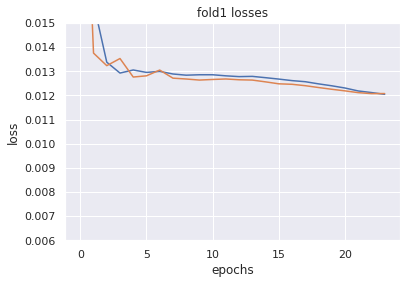

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65126, train_metric: 0.65119
valid_loss: 0.30767, valid_metric: 0.30715
-----EPOCH2-----
train_loss: 0.06758, train_metric: 0.06580
valid_loss: 0.02260, valid_metric: 0.02014
-----EPOCH3-----
train_loss: 0.02120, train_metric: 0.01848
valid_loss: 0.02028, valid_metric: 0.01742
-----EPOCH4-----
train_loss: 0.02016, train_metric: 0.01718
valid_loss: 0.01998, valid_metric: 0.01695
-----EPOCH5-----
train_loss: 0.02448, train_metric: 0.02139
valid_loss: 0.02009, valid_metric: 0.01686
-----EPOCH6-----
train_loss: 0.01994, train_metric: 0.01677
valid_loss: 0.02001, valid_metric: 0.01667
-----EPOCH7-----
train_loss: 0.01977, train_metric: 0.01656
valid_loss: 0.01996, valid_metric: 0.01666
-----EPOCH8-----
train_loss: 0.01967, train_metric: 0.01645
valid_loss: 0.01978, valid_metric: 0.01658
-----EPOCH9-----
train_loss: 0.01989, train_metric: 0.01667
valid_loss: 0.01987, valid_metric: 0.01660
-----EPOCH10-----
train_loss: 0.01960, train_metric: 0.01

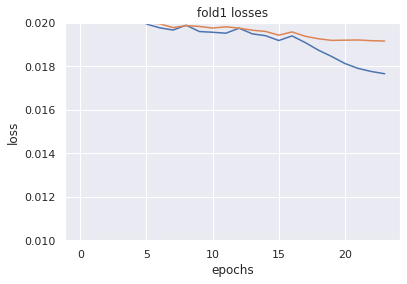

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51035, train_metric: 0.50993
valid_loss: 0.02954, valid_metric: 0.02750
-----EPOCH2-----
train_loss: 0.01609, train_metric: 0.01323
valid_loss: 0.01366, valid_metric: 0.01054
-----EPOCH3-----
train_loss: 0.01362, train_metric: 0.01036
valid_loss: 0.01303, valid_metric: 0.00981
-----EPOCH4-----
train_loss: 0.01306, train_metric: 0.00975
valid_loss: 0.01283, valid_metric: 0.00957
-----EPOCH5-----
train_loss: 0.01493, train_metric: 0.01147
valid_loss: 0.01334, valid_metric: 0.00984
-----EPOCH6-----
train_loss: 0.01323, train_metric: 0.00976
valid_loss: 0.01303, valid_metric: 0.00966
-----EPOCH7-----
train_loss: 0.01301, train_metric: 0.00968
valid_loss: 0.01289, valid_metric: 0.00960
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00962
valid_loss: 0.01284, valid_metric: 0.00960
-----EPOCH9-----
train_loss: 0.01288, train_metric: 0.00963
valid_loss: 0.01281, valid_metric: 0.00956
-----EPOCH10-----
train_loss: 0

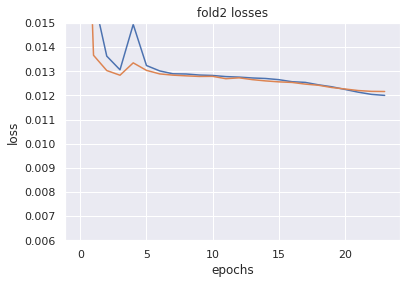

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65645, train_metric: 0.65638
valid_loss: 0.30768, valid_metric: 0.30716
-----EPOCH2-----
train_loss: 0.06752, train_metric: 0.06575
valid_loss: 0.02266, valid_metric: 0.02021
-----EPOCH3-----
train_loss: 0.02124, train_metric: 0.01853
valid_loss: 0.02021, valid_metric: 0.01735
-----EPOCH4-----
train_loss: 0.02008, train_metric: 0.01712
valid_loss: 0.01994, valid_metric: 0.01694
-----EPOCH5-----
train_loss: 0.02147, train_metric: 0.01832
valid_loss: 0.01999, valid_metric: 0.01668
-----EPOCH6-----
train_loss: 0.01982, train_metric: 0.01661
valid_loss: 0.01984, valid_metric: 0.01662
-----EPOCH7-----
train_loss: 0.01968, train_metric: 0.01645
valid_loss: 0.01975, valid_metric: 0.01649
-----EPOCH8-----
train_loss: 0.01957, train_metric: 0.01633
valid_loss: 0.01966, valid_metric: 0.01643
-----EPOCH9-----
train_loss: 0.01973, train_metric: 0.01649
valid_loss: 0.01980, valid_metric: 0.01652
-----EPOCH10-----
train_loss: 0.01955, train_metric: 0.01

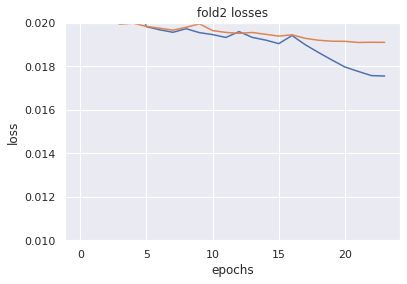

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50888, train_metric: 0.50845
valid_loss: 0.02810, valid_metric: 0.02553
-----EPOCH2-----
train_loss: 0.01574, train_metric: 0.01290
valid_loss: 0.01355, valid_metric: 0.01046
-----EPOCH3-----
train_loss: 0.01341, train_metric: 0.01019
valid_loss: 0.01294, valid_metric: 0.00974
-----EPOCH4-----
train_loss: 0.01310, train_metric: 0.00982
valid_loss: 0.01421, valid_metric: 0.01091
-----EPOCH5-----
train_loss: 0.01297, train_metric: 0.00967
valid_loss: 0.01289, valid_metric: 0.00963
-----EPOCH6-----
train_loss: 0.01289, train_metric: 0.00961
valid_loss: 0.01329, valid_metric: 0.01003
-----EPOCH7-----
train_loss: 0.01284, train_metric: 0.00958
valid_loss: 0.01281, valid_metric: 0.00954
-----EPOCH8-----
train_loss: 0.01290, train_metric: 0.00965
valid_loss: 0.01293, valid_metric: 0.00964
-----EPOCH9-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01271, valid_metric: 0.00943
-----EPOCH10-----
train_loss: 0

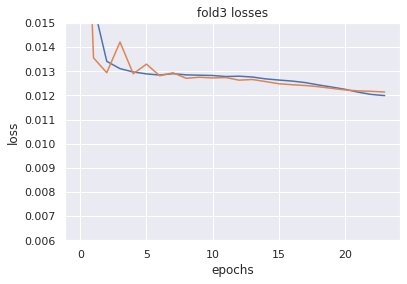

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65342, train_metric: 0.65335
valid_loss: 0.31093, valid_metric: 0.31041
-----EPOCH2-----
train_loss: 0.06788, train_metric: 0.06610
valid_loss: 0.02261, valid_metric: 0.02015
-----EPOCH3-----
train_loss: 0.02111, train_metric: 0.01840
valid_loss: 0.02038, valid_metric: 0.01751
-----EPOCH4-----
train_loss: 0.02001, train_metric: 0.01704
valid_loss: 0.02006, valid_metric: 0.01702
-----EPOCH5-----
train_loss: 0.02376, train_metric: 0.02059
valid_loss: 0.02023, valid_metric: 0.01696
-----EPOCH6-----
train_loss: 0.01983, train_metric: 0.01661
valid_loss: 0.02002, valid_metric: 0.01678
-----EPOCH7-----
train_loss: 0.01959, train_metric: 0.01636
valid_loss: 0.01996, valid_metric: 0.01667
-----EPOCH8-----
train_loss: 0.01954, train_metric: 0.01631
valid_loss: 0.01991, valid_metric: 0.01660
-----EPOCH9-----
train_loss: 0.01971, train_metric: 0.01647
valid_loss: 0.01994, valid_metric: 0.01668
-----EPOCH10-----
train_loss: 0.01951, train_metric: 0.01

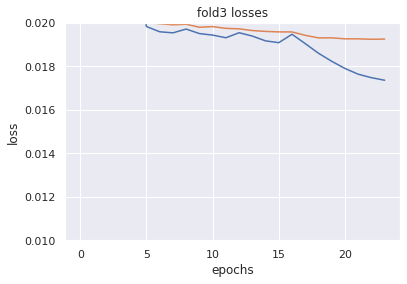

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50903, train_metric: 0.50860
valid_loss: 0.03348, valid_metric: 0.03083
-----EPOCH2-----
train_loss: 0.01592, train_metric: 0.01308
valid_loss: 0.01444, valid_metric: 0.01134
-----EPOCH3-----
train_loss: 0.01375, train_metric: 0.01049
valid_loss: 0.01384, valid_metric: 0.01044
-----EPOCH4-----
train_loss: 0.01315, train_metric: 0.00980
valid_loss: 0.01449, valid_metric: 0.01116
-----EPOCH5-----
train_loss: 0.01292, train_metric: 0.00960
valid_loss: 0.01297, valid_metric: 0.00971
-----EPOCH6-----
train_loss: 0.01318, train_metric: 0.00982
valid_loss: 0.01278, valid_metric: 0.00948
-----EPOCH7-----
train_loss: 0.01288, train_metric: 0.00959
valid_loss: 0.01272, valid_metric: 0.00948
-----EPOCH8-----
train_loss: 0.01287, train_metric: 0.00962
valid_loss: 0.01288, valid_metric: 0.00961
-----EPOCH9-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01294, valid_metric: 0.00970
-----EPOCH10-----
train_loss: 0

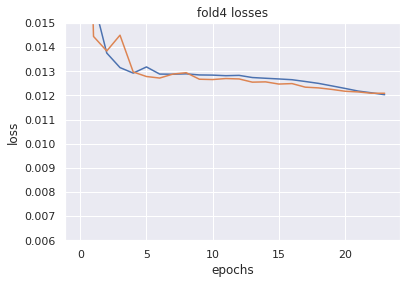

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65445, train_metric: 0.65438
valid_loss: 0.30918, valid_metric: 0.30866
-----EPOCH2-----
train_loss: 0.06746, train_metric: 0.06568
valid_loss: 0.02250, valid_metric: 0.02004
-----EPOCH3-----
train_loss: 0.02124, train_metric: 0.01852
valid_loss: 0.02020, valid_metric: 0.01733
-----EPOCH4-----
train_loss: 0.02009, train_metric: 0.01712
valid_loss: 0.01998, valid_metric: 0.01695
-----EPOCH5-----
train_loss: 0.02439, train_metric: 0.02126
valid_loss: 0.01997, valid_metric: 0.01673
-----EPOCH6-----
train_loss: 0.01985, train_metric: 0.01665
valid_loss: 0.01987, valid_metric: 0.01663
-----EPOCH7-----
train_loss: 0.01973, train_metric: 0.01650
valid_loss: 0.01986, valid_metric: 0.01656
-----EPOCH8-----
train_loss: 0.01951, train_metric: 0.01627
valid_loss: 0.01977, valid_metric: 0.01652
-----EPOCH9-----
train_loss: 0.01984, train_metric: 0.01660
valid_loss: 0.01986, valid_metric: 0.01660
-----EPOCH10-----
train_loss: 0.01966, train_metric: 0.01

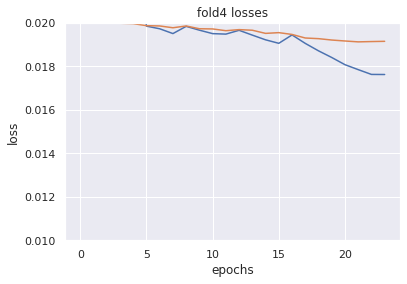

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50896, train_metric: 0.50853
valid_loss: 0.02491, valid_metric: 0.02268
-----EPOCH2-----
train_loss: 0.01605, train_metric: 0.01320
valid_loss: 0.01396, valid_metric: 0.01076
-----EPOCH3-----
train_loss: 0.01349, train_metric: 0.01023
valid_loss: 0.01325, valid_metric: 0.01000
-----EPOCH4-----
train_loss: 0.01321, train_metric: 0.00989
valid_loss: 0.01281, valid_metric: 0.00952
-----EPOCH5-----
train_loss: 0.01290, train_metric: 0.00959
valid_loss: 0.01283, valid_metric: 0.00950
-----EPOCH6-----
train_loss: 0.01296, train_metric: 0.00966
valid_loss: 0.01285, valid_metric: 0.00958
-----EPOCH7-----
train_loss: 0.01289, train_metric: 0.00962
valid_loss: 0.01355, valid_metric: 0.01028
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01275, valid_metric: 0.00949
-----EPOCH9-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01269, valid_metric: 0.00941
-----EPOCH10-----
train_loss: 0

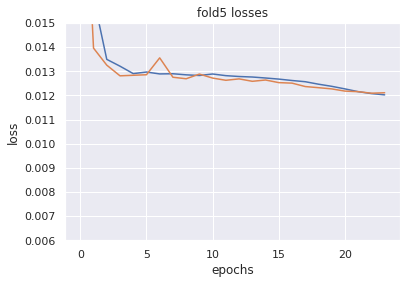

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65185, train_metric: 0.65178
valid_loss: 0.30530, valid_metric: 0.30478
-----EPOCH2-----
train_loss: 0.06664, train_metric: 0.06486
valid_loss: 0.02276, valid_metric: 0.02032
-----EPOCH3-----
train_loss: 0.02122, train_metric: 0.01851
valid_loss: 0.02041, valid_metric: 0.01754
-----EPOCH4-----
train_loss: 0.02007, train_metric: 0.01709
valid_loss: 0.02013, valid_metric: 0.01712
-----EPOCH5-----
train_loss: 0.02479, train_metric: 0.02162
valid_loss: 0.02015, valid_metric: 0.01688
-----EPOCH6-----
train_loss: 0.01976, train_metric: 0.01654
valid_loss: 0.02008, valid_metric: 0.01677
-----EPOCH7-----
train_loss: 0.01965, train_metric: 0.01642
valid_loss: 0.02002, valid_metric: 0.01672
-----EPOCH8-----
train_loss: 0.01952, train_metric: 0.01628
valid_loss: 0.01993, valid_metric: 0.01671
-----EPOCH9-----
train_loss: 0.01976, train_metric: 0.01653
valid_loss: 0.01998, valid_metric: 0.01669
-----EPOCH10-----
train_loss: 0.01956, train_metric: 0.01

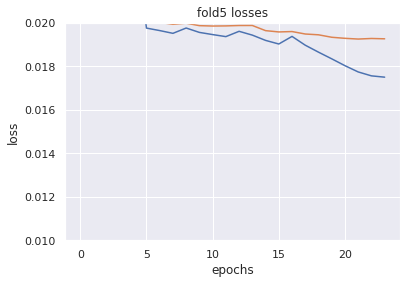

 
SEED : 2

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50934, train_metric: 0.50891
valid_loss: 0.02666, valid_metric: 0.02459
-----EPOCH2-----
train_loss: 0.01601, train_metric: 0.01317
valid_loss: 0.01378, valid_metric: 0.01070
-----EPOCH3-----
train_loss: 0.01360, train_metric: 0.01037
valid_loss: 0.01320, valid_metric: 0.00983
-----EPOCH4-----
train_loss: 0.01307, train_metric: 0.00974
valid_loss: 0.01559, valid_metric: 0.01229
-----EPOCH5-----
train_loss: 0.01298, train_metric: 0.00967
valid_loss: 0.01395, valid_metric: 0.01063
-----EPOCH6-----
train_loss: 0.01292, train_metric: 0.00963
valid_loss: 0.01404, valid_metric: 0.01076
-----EPOCH7-----
train_loss: 0.01294, train_metric: 0.00966
valid_loss: 0.01267, valid_metric: 0.00941
-----EPOCH8-----
train_loss: 0.01294, train_metric: 0.00968
valid_loss: 0.01275, valid_metric: 0.00950
-----EPOCH9-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01271, valid_metric: 0.00942
-----EPOCH10-----
t

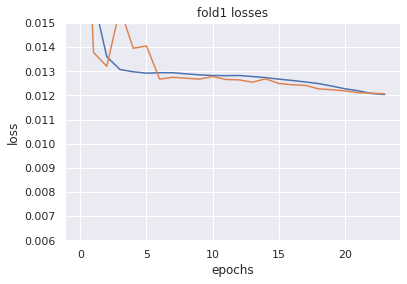

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65166, train_metric: 0.65159
valid_loss: 0.30424, valid_metric: 0.30371
-----EPOCH2-----
train_loss: 0.06619, train_metric: 0.06441
valid_loss: 0.02270, valid_metric: 0.02025
-----EPOCH3-----
train_loss: 0.02118, train_metric: 0.01846
valid_loss: 0.02043, valid_metric: 0.01757
-----EPOCH4-----
train_loss: 0.02005, train_metric: 0.01708
valid_loss: 0.01999, valid_metric: 0.01696
-----EPOCH5-----
train_loss: 0.02262, train_metric: 0.01941
valid_loss: 0.02015, valid_metric: 0.01679
-----EPOCH6-----
train_loss: 0.02003, train_metric: 0.01679
valid_loss: 0.02002, valid_metric: 0.01665
-----EPOCH7-----
train_loss: 0.01976, train_metric: 0.01652
valid_loss: 0.01984, valid_metric: 0.01653
-----EPOCH8-----
train_loss: 0.01968, train_metric: 0.01643
valid_loss: 0.01986, valid_metric: 0.01664
-----EPOCH9-----
train_loss: 0.01986, train_metric: 0.01663
valid_loss: 0.01993, valid_metric: 0.01660
-----EPOCH10-----
train_loss: 0.01959, train_metric: 0.01

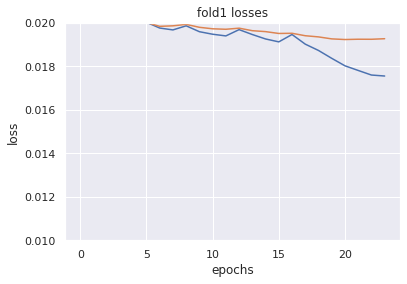

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50919, train_metric: 0.50876
valid_loss: 0.02954, valid_metric: 0.02751
-----EPOCH2-----
train_loss: 0.01612, train_metric: 0.01326
valid_loss: 0.01363, valid_metric: 0.01042
-----EPOCH3-----
train_loss: 0.01354, train_metric: 0.01029
valid_loss: 0.01327, valid_metric: 0.01010
-----EPOCH4-----
train_loss: 0.01311, train_metric: 0.00982
valid_loss: 0.01417, valid_metric: 0.01095
-----EPOCH5-----
train_loss: 0.01307, train_metric: 0.00977
valid_loss: 0.01288, valid_metric: 0.00960
-----EPOCH6-----
train_loss: 0.01286, train_metric: 0.00957
valid_loss: 0.01287, valid_metric: 0.00966
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00960
valid_loss: 0.01365, valid_metric: 0.01044
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01285, valid_metric: 0.00962
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00960
valid_loss: 0.01287, valid_metric: 0.00964
-----EPOCH10-----
train_loss: 0

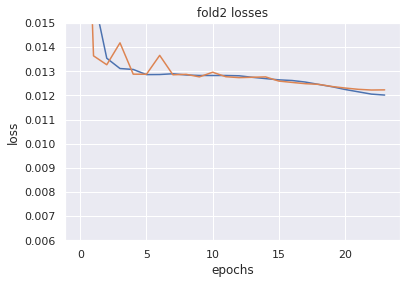

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65336, train_metric: 0.65329
valid_loss: 0.30651, valid_metric: 0.30599
-----EPOCH2-----
train_loss: 0.06688, train_metric: 0.06510
valid_loss: 0.02257, valid_metric: 0.02011
-----EPOCH3-----
train_loss: 0.02117, train_metric: 0.01846
valid_loss: 0.02038, valid_metric: 0.01750
-----EPOCH4-----
train_loss: 0.02004, train_metric: 0.01707
valid_loss: 0.02007, valid_metric: 0.01703
-----EPOCH5-----
train_loss: 0.02641, train_metric: 0.02330
valid_loss: 0.02010, valid_metric: 0.01693
-----EPOCH6-----
train_loss: 0.01975, train_metric: 0.01657
valid_loss: 0.02001, valid_metric: 0.01678
-----EPOCH7-----
train_loss: 0.01958, train_metric: 0.01636
valid_loss: 0.01997, valid_metric: 0.01666
-----EPOCH8-----
train_loss: 0.01953, train_metric: 0.01630
valid_loss: 0.01994, valid_metric: 0.01668
-----EPOCH9-----
train_loss: 0.01979, train_metric: 0.01656
valid_loss: 0.01988, valid_metric: 0.01661
-----EPOCH10-----
train_loss: 0.01951, train_metric: 0.01

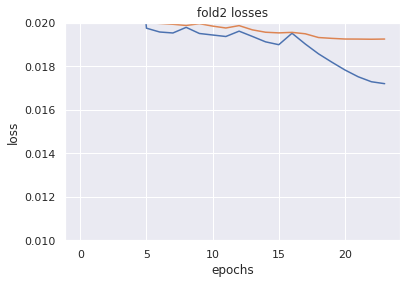

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50845, train_metric: 0.50802
valid_loss: 0.02390, valid_metric: 0.02176
-----EPOCH2-----
train_loss: 0.01588, train_metric: 0.01304
valid_loss: 0.01357, valid_metric: 0.01046
-----EPOCH3-----
train_loss: 0.01327, train_metric: 0.01006
valid_loss: 0.01314, valid_metric: 0.00990
-----EPOCH4-----
train_loss: 0.01299, train_metric: 0.00971
valid_loss: 0.01786, valid_metric: 0.01440
-----EPOCH5-----
train_loss: 0.01309, train_metric: 0.00977
valid_loss: 0.01475, valid_metric: 0.01148
-----EPOCH6-----
train_loss: 0.01292, train_metric: 0.00962
valid_loss: 0.01352, valid_metric: 0.01024
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00959
valid_loss: 0.01369, valid_metric: 0.01046
-----EPOCH8-----
train_loss: 0.01288, train_metric: 0.00962
valid_loss: 0.01285, valid_metric: 0.00958
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00959
valid_loss: 0.01278, valid_metric: 0.00953
-----EPOCH10-----
train_loss: 0

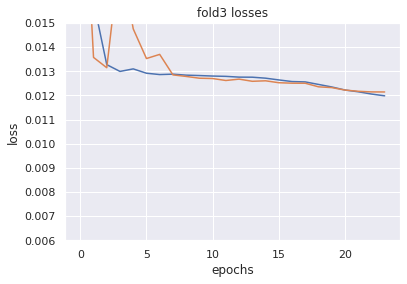

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65092, train_metric: 0.65085
valid_loss: 0.30224, valid_metric: 0.30171
-----EPOCH2-----
train_loss: 0.06661, train_metric: 0.06483
valid_loss: 0.02246, valid_metric: 0.01999
-----EPOCH3-----
train_loss: 0.02112, train_metric: 0.01841
valid_loss: 0.02030, valid_metric: 0.01742
-----EPOCH4-----
train_loss: 0.02001, train_metric: 0.01704
valid_loss: 0.01997, valid_metric: 0.01693
-----EPOCH5-----
train_loss: 0.02402, train_metric: 0.02087
valid_loss: 0.02004, valid_metric: 0.01676
-----EPOCH6-----
train_loss: 0.01975, train_metric: 0.01655
valid_loss: 0.01996, valid_metric: 0.01667
-----EPOCH7-----
train_loss: 0.01967, train_metric: 0.01644
valid_loss: 0.01984, valid_metric: 0.01662
-----EPOCH8-----
train_loss: 0.01951, train_metric: 0.01627
valid_loss: 0.01989, valid_metric: 0.01659
-----EPOCH9-----
train_loss: 0.01983, train_metric: 0.01658
valid_loss: 0.01985, valid_metric: 0.01663
-----EPOCH10-----
train_loss: 0.01959, train_metric: 0.01

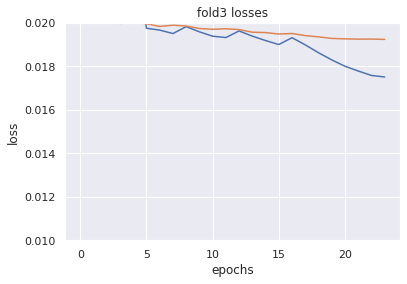

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50922, train_metric: 0.50879
valid_loss: 0.02735, valid_metric: 0.02505
-----EPOCH2-----
train_loss: 0.01591, train_metric: 0.01306
valid_loss: 0.01356, valid_metric: 0.01047
-----EPOCH3-----
train_loss: 0.01335, train_metric: 0.01013
valid_loss: 0.01288, valid_metric: 0.00967
-----EPOCH4-----
train_loss: 0.01312, train_metric: 0.00983
valid_loss: 0.01378, valid_metric: 0.01040
-----EPOCH5-----
train_loss: 0.01302, train_metric: 0.00969
valid_loss: 0.01270, valid_metric: 0.00939
-----EPOCH6-----
train_loss: 0.01300, train_metric: 0.00969
valid_loss: 0.01270, valid_metric: 0.00943
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00959
valid_loss: 0.01481, valid_metric: 0.01142
-----EPOCH8-----
train_loss: 0.01298, train_metric: 0.00972
valid_loss: 0.01284, valid_metric: 0.00959
-----EPOCH9-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01281, valid_metric: 0.00959
-----EPOCH10-----
train_loss: 0

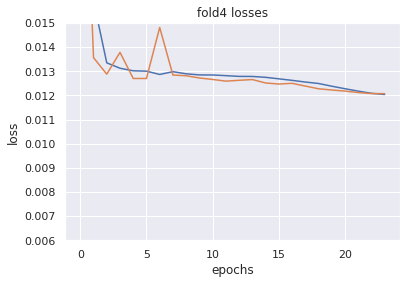

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65308, train_metric: 0.65300
valid_loss: 0.30692, valid_metric: 0.30640
-----EPOCH2-----
train_loss: 0.06667, train_metric: 0.06488
valid_loss: 0.02252, valid_metric: 0.02006
-----EPOCH3-----
train_loss: 0.02118, train_metric: 0.01847
valid_loss: 0.02035, valid_metric: 0.01748
-----EPOCH4-----
train_loss: 0.02005, train_metric: 0.01707
valid_loss: 0.01997, valid_metric: 0.01694
-----EPOCH5-----
train_loss: 0.02265, train_metric: 0.01947
valid_loss: 0.02013, valid_metric: 0.01674
-----EPOCH6-----
train_loss: 0.01990, train_metric: 0.01669
valid_loss: 0.01992, valid_metric: 0.01667
-----EPOCH7-----
train_loss: 0.02006, train_metric: 0.01683
valid_loss: 0.01991, valid_metric: 0.01655
-----EPOCH8-----
train_loss: 0.01961, train_metric: 0.01636
valid_loss: 0.01977, valid_metric: 0.01651
-----EPOCH9-----
train_loss: 0.01984, train_metric: 0.01659
valid_loss: 0.01982, valid_metric: 0.01656
-----EPOCH10-----
train_loss: 0.01960, train_metric: 0.01

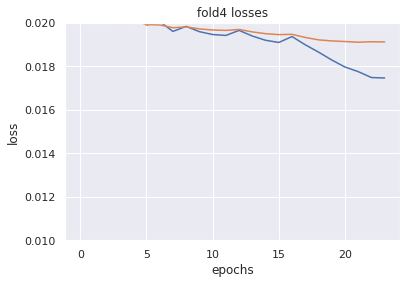

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50984, train_metric: 0.50941
valid_loss: 0.02372, valid_metric: 0.02151
-----EPOCH2-----
train_loss: 0.01588, train_metric: 0.01304
valid_loss: 0.01339, valid_metric: 0.01028
-----EPOCH3-----
train_loss: 0.01335, train_metric: 0.01013
valid_loss: 0.01355, valid_metric: 0.01027
-----EPOCH4-----
train_loss: 0.01307, train_metric: 0.00977
valid_loss: 0.01342, valid_metric: 0.01002
-----EPOCH5-----
train_loss: 0.01291, train_metric: 0.00960
valid_loss: 0.01271, valid_metric: 0.00945
-----EPOCH6-----
train_loss: 0.01287, train_metric: 0.00959
valid_loss: 0.01267, valid_metric: 0.00938
-----EPOCH7-----
train_loss: 0.01282, train_metric: 0.00956
valid_loss: 0.01265, valid_metric: 0.00940
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01314, valid_metric: 0.00990
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00958
valid_loss: 0.01273, valid_metric: 0.00941
-----EPOCH10-----
train_loss: 0

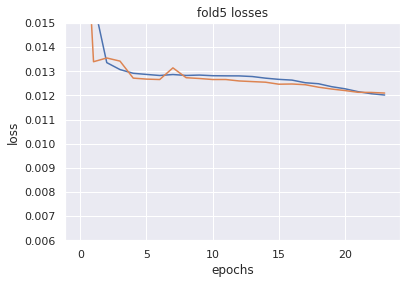

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65150, train_metric: 0.65143
valid_loss: 0.30995, valid_metric: 0.30943
-----EPOCH2-----
train_loss: 0.06703, train_metric: 0.06525
valid_loss: 0.02275, valid_metric: 0.02030
-----EPOCH3-----
train_loss: 0.02114, train_metric: 0.01842
valid_loss: 0.02038, valid_metric: 0.01749
-----EPOCH4-----
train_loss: 0.02000, train_metric: 0.01702
valid_loss: 0.02012, valid_metric: 0.01710
-----EPOCH5-----
train_loss: 0.02197, train_metric: 0.01879
valid_loss: 0.02037, valid_metric: 0.01702
-----EPOCH6-----
train_loss: 0.01974, train_metric: 0.01652
valid_loss: 0.02005, valid_metric: 0.01681
-----EPOCH7-----
train_loss: 0.01961, train_metric: 0.01638
valid_loss: 0.02000, valid_metric: 0.01677
-----EPOCH8-----
train_loss: 0.01951, train_metric: 0.01628
valid_loss: 0.01991, valid_metric: 0.01669
-----EPOCH9-----
train_loss: 0.01969, train_metric: 0.01645
valid_loss: 0.02003, valid_metric: 0.01677
-----EPOCH10-----
train_loss: 0.01950, train_metric: 0.01

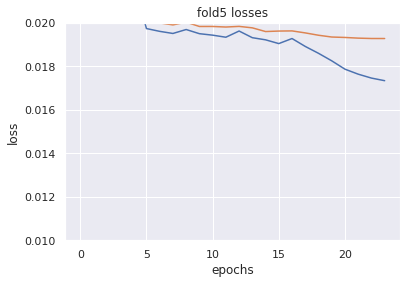

 
SEED : 3

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50829, train_metric: 0.50786
valid_loss: 0.02469, valid_metric: 0.02248
-----EPOCH2-----
train_loss: 0.01606, train_metric: 0.01322
valid_loss: 0.01350, valid_metric: 0.01034
-----EPOCH3-----
train_loss: 0.01336, train_metric: 0.01013
valid_loss: 0.01308, valid_metric: 0.00990
-----EPOCH4-----
train_loss: 0.01349, train_metric: 0.01012
valid_loss: 0.01306, valid_metric: 0.00983
-----EPOCH5-----
train_loss: 0.01301, train_metric: 0.00968
valid_loss: 0.01465, valid_metric: 0.01162
-----EPOCH6-----
train_loss: 0.01331, train_metric: 0.00993
valid_loss: 0.01348, valid_metric: 0.01024
-----EPOCH7-----
train_loss: 0.01290, train_metric: 0.00960
valid_loss: 0.01285, valid_metric: 0.00955
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00960
valid_loss: 0.01295, valid_metric: 0.00968
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00960
valid_loss: 0.01266, valid_metric: 0.00939
-----EPOCH10-----
t

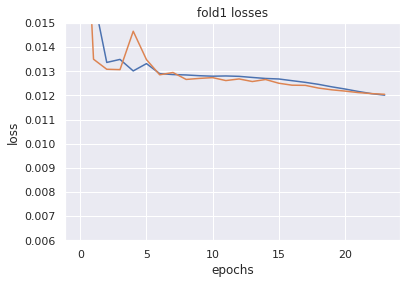

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65281, train_metric: 0.65273
valid_loss: 0.30683, valid_metric: 0.30631
-----EPOCH2-----
train_loss: 0.06724, train_metric: 0.06546
valid_loss: 0.02274, valid_metric: 0.02029
-----EPOCH3-----
train_loss: 0.02115, train_metric: 0.01844
valid_loss: 0.02030, valid_metric: 0.01743
-----EPOCH4-----
train_loss: 0.01997, train_metric: 0.01699
valid_loss: 0.01996, valid_metric: 0.01693
-----EPOCH5-----
train_loss: 0.02413, train_metric: 0.02099
valid_loss: 0.02015, valid_metric: 0.01679
-----EPOCH6-----
train_loss: 0.01981, train_metric: 0.01658
valid_loss: 0.01989, valid_metric: 0.01661
-----EPOCH7-----
train_loss: 0.01965, train_metric: 0.01642
valid_loss: 0.01985, valid_metric: 0.01659
-----EPOCH8-----
train_loss: 0.01952, train_metric: 0.01627
valid_loss: 0.01980, valid_metric: 0.01650
-----EPOCH9-----
train_loss: 0.01974, train_metric: 0.01649
valid_loss: 0.01987, valid_metric: 0.01657
-----EPOCH10-----
train_loss: 0.01966, train_metric: 0.01

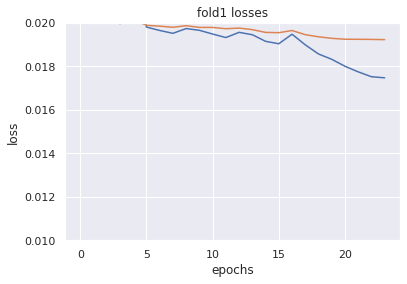

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50963, train_metric: 0.50920
valid_loss: 0.02477, valid_metric: 0.02262
-----EPOCH2-----
train_loss: 0.01593, train_metric: 0.01311
valid_loss: 0.01429, valid_metric: 0.01128
-----EPOCH3-----
train_loss: 0.01342, train_metric: 0.01018
valid_loss: 0.01402, valid_metric: 0.01078
-----EPOCH4-----
train_loss: 0.01316, train_metric: 0.00985
valid_loss: 0.01371, valid_metric: 0.01047
-----EPOCH5-----
train_loss: 0.01276, train_metric: 0.00946
valid_loss: 0.01275, valid_metric: 0.00948
-----EPOCH6-----
train_loss: 0.01284, train_metric: 0.00957
valid_loss: 0.01331, valid_metric: 0.01008
-----EPOCH7-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01342, valid_metric: 0.01017
-----EPOCH8-----
train_loss: 0.01280, train_metric: 0.00955
valid_loss: 0.01288, valid_metric: 0.00965
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00957
valid_loss: 0.01288, valid_metric: 0.00969
-----EPOCH10-----
train_loss: 0

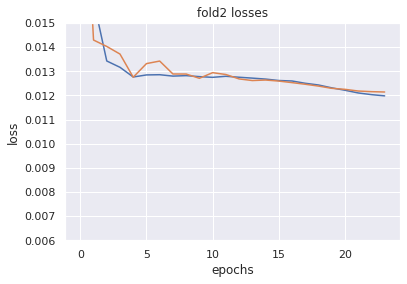

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65015, train_metric: 0.65008
valid_loss: 0.30400, valid_metric: 0.30347
-----EPOCH2-----
train_loss: 0.06732, train_metric: 0.06554
valid_loss: 0.02252, valid_metric: 0.02006
-----EPOCH3-----
train_loss: 0.02122, train_metric: 0.01851
valid_loss: 0.02024, valid_metric: 0.01737
-----EPOCH4-----
train_loss: 0.02000, train_metric: 0.01702
valid_loss: 0.01987, valid_metric: 0.01684
-----EPOCH5-----
train_loss: 0.02608, train_metric: 0.02300
valid_loss: 0.01988, valid_metric: 0.01663
-----EPOCH6-----
train_loss: 0.01980, train_metric: 0.01662
valid_loss: 0.01969, valid_metric: 0.01645
-----EPOCH7-----
train_loss: 0.01961, train_metric: 0.01639
valid_loss: 0.01972, valid_metric: 0.01640
-----EPOCH8-----
train_loss: 0.01946, train_metric: 0.01624
valid_loss: 0.01966, valid_metric: 0.01641
-----EPOCH9-----
train_loss: 0.01970, train_metric: 0.01646
valid_loss: 0.01974, valid_metric: 0.01646
-----EPOCH10-----
train_loss: 0.01950, train_metric: 0.01

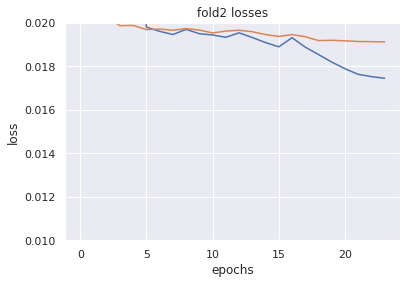

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50879, train_metric: 0.50836
valid_loss: 0.02705, valid_metric: 0.02497
-----EPOCH2-----
train_loss: 0.01594, train_metric: 0.01311
valid_loss: 0.01387, valid_metric: 0.01074
-----EPOCH3-----
train_loss: 0.01350, train_metric: 0.01026
valid_loss: 0.01476, valid_metric: 0.01147
-----EPOCH4-----
train_loss: 0.01297, train_metric: 0.00968
valid_loss: 0.01403, valid_metric: 0.01074
-----EPOCH5-----
train_loss: 0.01312, train_metric: 0.00981
valid_loss: 0.01340, valid_metric: 0.01001
-----EPOCH6-----
train_loss: 0.01293, train_metric: 0.00960
valid_loss: 0.01444, valid_metric: 0.01084
-----EPOCH7-----
train_loss: 0.01300, train_metric: 0.00970
valid_loss: 0.01275, valid_metric: 0.00951
-----EPOCH8-----
train_loss: 0.01287, train_metric: 0.00962
valid_loss: 0.01273, valid_metric: 0.00950
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00959
valid_loss: 0.01309, valid_metric: 0.00985
-----EPOCH10-----
train_loss: 0

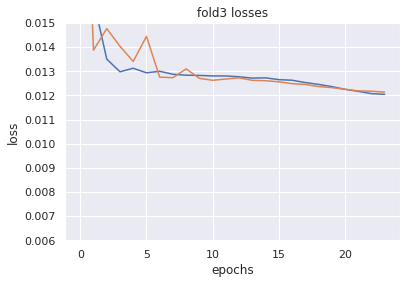

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65187, train_metric: 0.65180
valid_loss: 0.30887, valid_metric: 0.30835
-----EPOCH2-----
train_loss: 0.06771, train_metric: 0.06594
valid_loss: 0.02276, valid_metric: 0.02031
-----EPOCH3-----
train_loss: 0.02130, train_metric: 0.01859
valid_loss: 0.02045, valid_metric: 0.01759
-----EPOCH4-----
train_loss: 0.02010, train_metric: 0.01713
valid_loss: 0.02010, valid_metric: 0.01706
-----EPOCH5-----
train_loss: 0.02561, train_metric: 0.02244
valid_loss: 0.02008, valid_metric: 0.01681
-----EPOCH6-----
train_loss: 0.01981, train_metric: 0.01659
valid_loss: 0.02004, valid_metric: 0.01674
-----EPOCH7-----
train_loss: 0.01967, train_metric: 0.01645
valid_loss: 0.02000, valid_metric: 0.01674
-----EPOCH8-----
train_loss: 0.01956, train_metric: 0.01632
valid_loss: 0.01987, valid_metric: 0.01661
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01656
valid_loss: 0.02006, valid_metric: 0.01677
-----EPOCH10-----
train_loss: 0.01955, train_metric: 0.01

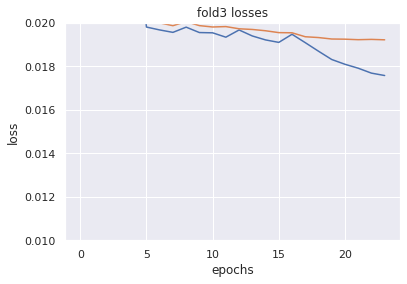

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51033, train_metric: 0.50990
valid_loss: 0.02432, valid_metric: 0.02200
-----EPOCH2-----
train_loss: 0.01624, train_metric: 0.01339
valid_loss: 0.01363, valid_metric: 0.01047
-----EPOCH3-----
train_loss: 0.01396, train_metric: 0.01063
valid_loss: 0.01383, valid_metric: 0.01049
-----EPOCH4-----
train_loss: 0.01306, train_metric: 0.00971
valid_loss: 0.01395, valid_metric: 0.01065
-----EPOCH5-----
train_loss: 0.01298, train_metric: 0.00967
valid_loss: 0.01276, valid_metric: 0.00942
-----EPOCH6-----
train_loss: 0.01311, train_metric: 0.00976
valid_loss: 0.01333, valid_metric: 0.01002
-----EPOCH7-----
train_loss: 0.01288, train_metric: 0.00959
valid_loss: 0.01384, valid_metric: 0.01062
-----EPOCH8-----
train_loss: 0.01288, train_metric: 0.00963
valid_loss: 0.01266, valid_metric: 0.00941
-----EPOCH9-----
train_loss: 0.01289, train_metric: 0.00963
valid_loss: 0.01284, valid_metric: 0.00958
-----EPOCH10-----
train_loss: 0

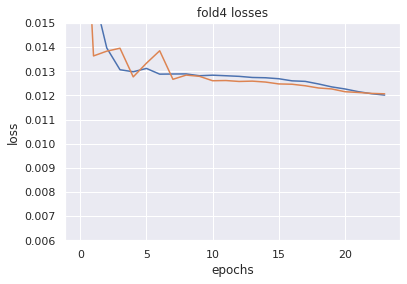

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65321, train_metric: 0.65314
valid_loss: 0.30431, valid_metric: 0.30378
-----EPOCH2-----
train_loss: 0.06715, train_metric: 0.06537
valid_loss: 0.02261, valid_metric: 0.02015
-----EPOCH3-----
train_loss: 0.02126, train_metric: 0.01855
valid_loss: 0.02017, valid_metric: 0.01729
-----EPOCH4-----
train_loss: 0.02008, train_metric: 0.01711
valid_loss: 0.02000, valid_metric: 0.01698
-----EPOCH5-----
train_loss: 0.02187, train_metric: 0.01869
valid_loss: 0.02004, valid_metric: 0.01677
-----EPOCH6-----
train_loss: 0.01982, train_metric: 0.01660
valid_loss: 0.01995, valid_metric: 0.01668
-----EPOCH7-----
train_loss: 0.01971, train_metric: 0.01648
valid_loss: 0.01985, valid_metric: 0.01662
-----EPOCH8-----
train_loss: 0.01958, train_metric: 0.01635
valid_loss: 0.01978, valid_metric: 0.01649
-----EPOCH9-----
train_loss: 0.01988, train_metric: 0.01665
valid_loss: 0.01996, valid_metric: 0.01664
-----EPOCH10-----
train_loss: 0.01963, train_metric: 0.01

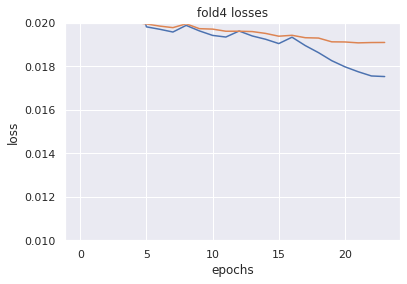

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50868, train_metric: 0.50825
valid_loss: 0.02368, valid_metric: 0.02135
-----EPOCH2-----
train_loss: 0.01581, train_metric: 0.01298
valid_loss: 0.01373, valid_metric: 0.01064
-----EPOCH3-----
train_loss: 0.01340, train_metric: 0.01019
valid_loss: 0.01293, valid_metric: 0.00968
-----EPOCH4-----
train_loss: 0.01302, train_metric: 0.00974
valid_loss: 0.01270, valid_metric: 0.00947
-----EPOCH5-----
train_loss: 0.01301, train_metric: 0.00969
valid_loss: 0.01270, valid_metric: 0.00939
-----EPOCH6-----
train_loss: 0.01286, train_metric: 0.00956
valid_loss: 0.01266, valid_metric: 0.00938
-----EPOCH7-----
train_loss: 0.01287, train_metric: 0.00961
valid_loss: 0.01327, valid_metric: 0.01001
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01265, valid_metric: 0.00939
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00959
valid_loss: 0.01301, valid_metric: 0.00972
-----EPOCH10-----
train_loss: 0

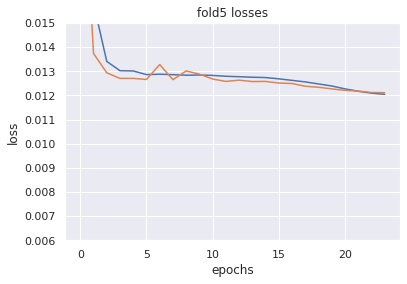

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65114, train_metric: 0.65107
valid_loss: 0.30880, valid_metric: 0.30828
-----EPOCH2-----
train_loss: 0.06747, train_metric: 0.06569
valid_loss: 0.02271, valid_metric: 0.02025
-----EPOCH3-----
train_loss: 0.02120, train_metric: 0.01848
valid_loss: 0.02043, valid_metric: 0.01756
-----EPOCH4-----
train_loss: 0.02011, train_metric: 0.01714
valid_loss: 0.02014, valid_metric: 0.01713
-----EPOCH5-----
train_loss: 0.02292, train_metric: 0.01980
valid_loss: 0.02013, valid_metric: 0.01696
-----EPOCH6-----
train_loss: 0.01994, train_metric: 0.01675
valid_loss: 0.02006, valid_metric: 0.01682
-----EPOCH7-----
train_loss: 0.01975, train_metric: 0.01653
valid_loss: 0.01998, valid_metric: 0.01678
-----EPOCH8-----
train_loss: 0.01964, train_metric: 0.01641
valid_loss: 0.02001, valid_metric: 0.01675
-----EPOCH9-----
train_loss: 0.02002, train_metric: 0.01678
valid_loss: 0.02002, valid_metric: 0.01673
-----EPOCH10-----
train_loss: 0.01964, train_metric: 0.01

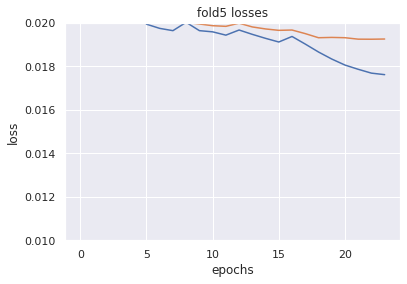

 
SEED : 4

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51041, train_metric: 0.50998
valid_loss: 0.03150, valid_metric: 0.02943
-----EPOCH2-----
train_loss: 0.01595, train_metric: 0.01312
valid_loss: 0.01380, valid_metric: 0.01065
-----EPOCH3-----
train_loss: 0.01342, train_metric: 0.01019
valid_loss: 0.01765, valid_metric: 0.01445
-----EPOCH4-----
train_loss: 0.01385, train_metric: 0.01044
valid_loss: 0.01287, valid_metric: 0.00945
-----EPOCH5-----
train_loss: 0.01295, train_metric: 0.00960
valid_loss: 0.01280, valid_metric: 0.00944
-----EPOCH6-----
train_loss: 0.01294, train_metric: 0.00964
valid_loss: 0.01284, valid_metric: 0.00958
-----EPOCH7-----
train_loss: 0.01287, train_metric: 0.00961
valid_loss: 0.01282, valid_metric: 0.00960
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01391, valid_metric: 0.01062
-----EPOCH9-----
train_loss: 0.01287, train_metric: 0.00962
valid_loss: 0.01266, valid_metric: 0.00939
-----EPOCH10-----
t

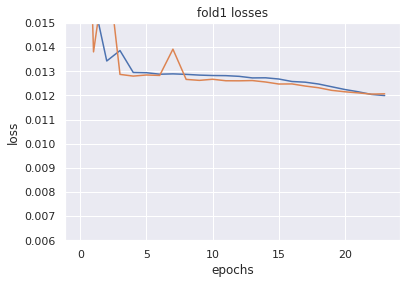

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65544, train_metric: 0.65537
valid_loss: 0.30618, valid_metric: 0.30565
-----EPOCH2-----
train_loss: 0.06713, train_metric: 0.06536
valid_loss: 0.02260, valid_metric: 0.02014
-----EPOCH3-----
train_loss: 0.02115, train_metric: 0.01844
valid_loss: 0.02033, valid_metric: 0.01747
-----EPOCH4-----
train_loss: 0.01999, train_metric: 0.01702
valid_loss: 0.01993, valid_metric: 0.01689
-----EPOCH5-----
train_loss: 0.02265, train_metric: 0.01953
valid_loss: 0.02003, valid_metric: 0.01676
-----EPOCH6-----
train_loss: 0.01978, train_metric: 0.01658
valid_loss: 0.01996, valid_metric: 0.01667
-----EPOCH7-----
train_loss: 0.01963, train_metric: 0.01640
valid_loss: 0.01984, valid_metric: 0.01651
-----EPOCH8-----
train_loss: 0.01952, train_metric: 0.01628
valid_loss: 0.01979, valid_metric: 0.01658
-----EPOCH9-----
train_loss: 0.01971, train_metric: 0.01648
valid_loss: 0.01989, valid_metric: 0.01669
-----EPOCH10-----
train_loss: 0.01950, train_metric: 0.01

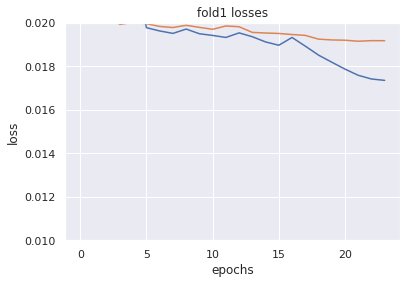

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50970, train_metric: 0.50927
valid_loss: 0.04517, valid_metric: 0.04317
-----EPOCH2-----
train_loss: 0.01586, train_metric: 0.01302
valid_loss: 0.01491, valid_metric: 0.01178
-----EPOCH3-----
train_loss: 0.01368, train_metric: 0.01037
valid_loss: 0.01293, valid_metric: 0.00961
-----EPOCH4-----
train_loss: 0.01306, train_metric: 0.00972
valid_loss: 0.01288, valid_metric: 0.00960
-----EPOCH5-----
train_loss: 0.01285, train_metric: 0.00954
valid_loss: 0.01289, valid_metric: 0.00963
-----EPOCH6-----
train_loss: 0.01282, train_metric: 0.00954
valid_loss: 0.01282, valid_metric: 0.00957
-----EPOCH7-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01323, valid_metric: 0.00997
-----EPOCH8-----
train_loss: 0.01284, train_metric: 0.00958
valid_loss: 0.01283, valid_metric: 0.00959
-----EPOCH9-----
train_loss: 0.01278, train_metric: 0.00954
valid_loss: 0.01290, valid_metric: 0.00968
-----EPOCH10-----
train_loss: 0

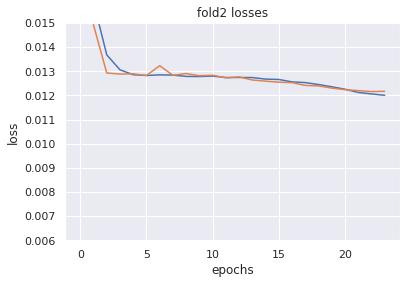

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65232, train_metric: 0.65225
valid_loss: 0.30702, valid_metric: 0.30649
-----EPOCH2-----
train_loss: 0.06744, train_metric: 0.06566
valid_loss: 0.02244, valid_metric: 0.01998
-----EPOCH3-----
train_loss: 0.02121, train_metric: 0.01850
valid_loss: 0.02027, valid_metric: 0.01739
-----EPOCH4-----
train_loss: 0.02008, train_metric: 0.01710
valid_loss: 0.01993, valid_metric: 0.01691
-----EPOCH5-----
train_loss: 0.02416, train_metric: 0.02101
valid_loss: 0.01997, valid_metric: 0.01673
-----EPOCH6-----
train_loss: 0.01993, train_metric: 0.01673
valid_loss: 0.01985, valid_metric: 0.01660
-----EPOCH7-----
train_loss: 0.01973, train_metric: 0.01651
valid_loss: 0.01979, valid_metric: 0.01652
-----EPOCH8-----
train_loss: 0.01962, train_metric: 0.01639
valid_loss: 0.01971, valid_metric: 0.01652
-----EPOCH9-----
train_loss: 0.01985, train_metric: 0.01662
valid_loss: 0.01973, valid_metric: 0.01648
-----EPOCH10-----
train_loss: 0.01959, train_metric: 0.01

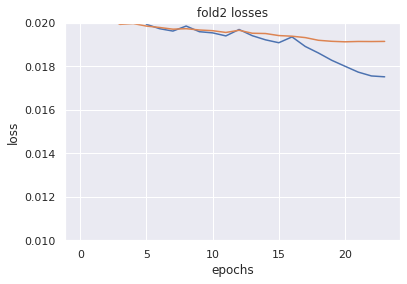

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50914, train_metric: 0.50871
valid_loss: 0.02551, valid_metric: 0.02333
-----EPOCH2-----
train_loss: 0.01597, train_metric: 0.01313
valid_loss: 0.01391, valid_metric: 0.01082
-----EPOCH3-----
train_loss: 0.01358, train_metric: 0.01036
valid_loss: 0.01351, valid_metric: 0.01035
-----EPOCH4-----
train_loss: 0.01324, train_metric: 0.00991
valid_loss: 0.01277, valid_metric: 0.00947
-----EPOCH5-----
train_loss: 0.01297, train_metric: 0.00965
valid_loss: 0.01306, valid_metric: 0.00972
-----EPOCH6-----
train_loss: 0.01293, train_metric: 0.00963
valid_loss: 0.01270, valid_metric: 0.00944
-----EPOCH7-----
train_loss: 0.01283, train_metric: 0.00956
valid_loss: 0.01275, valid_metric: 0.00947
-----EPOCH8-----
train_loss: 0.01283, train_metric: 0.00957
valid_loss: 0.01269, valid_metric: 0.00940
-----EPOCH9-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01323, valid_metric: 0.01000
-----EPOCH10-----
train_loss: 0

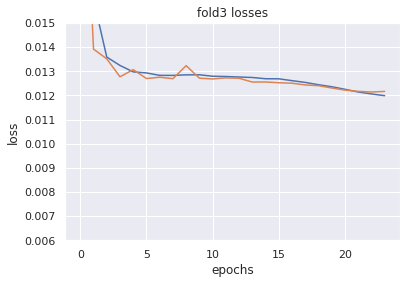

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65483, train_metric: 0.65476
valid_loss: 0.30841, valid_metric: 0.30789
-----EPOCH2-----
train_loss: 0.06770, train_metric: 0.06592
valid_loss: 0.02261, valid_metric: 0.02015
-----EPOCH3-----
train_loss: 0.02123, train_metric: 0.01851
valid_loss: 0.02036, valid_metric: 0.01749
-----EPOCH4-----
train_loss: 0.02009, train_metric: 0.01712
valid_loss: 0.02004, valid_metric: 0.01702
-----EPOCH5-----
train_loss: 0.02291, train_metric: 0.01975
valid_loss: 0.02009, valid_metric: 0.01686
-----EPOCH6-----
train_loss: 0.01980, train_metric: 0.01659
valid_loss: 0.02006, valid_metric: 0.01686
-----EPOCH7-----
train_loss: 0.01966, train_metric: 0.01644
valid_loss: 0.01997, valid_metric: 0.01676
-----EPOCH8-----
train_loss: 0.01957, train_metric: 0.01633
valid_loss: 0.01988, valid_metric: 0.01663
-----EPOCH9-----
train_loss: 0.01993, train_metric: 0.01668
valid_loss: 0.02000, valid_metric: 0.01670
-----EPOCH10-----
train_loss: 0.01955, train_metric: 0.01

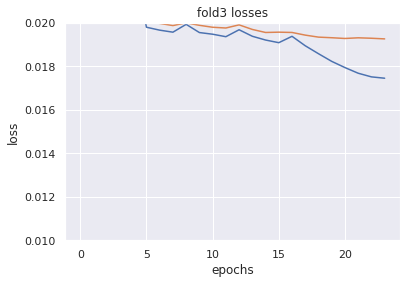

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51039, train_metric: 0.50997
valid_loss: 0.03168, valid_metric: 0.02963
-----EPOCH2-----
train_loss: 0.01602, train_metric: 0.01315
valid_loss: 0.01375, valid_metric: 0.01061
-----EPOCH3-----
train_loss: 0.01352, train_metric: 0.01029
valid_loss: 0.01286, valid_metric: 0.00953
-----EPOCH4-----
train_loss: 0.01296, train_metric: 0.00965
valid_loss: 0.01281, valid_metric: 0.00957
-----EPOCH5-----
train_loss: 0.01288, train_metric: 0.00957
valid_loss: 0.01271, valid_metric: 0.00946
-----EPOCH6-----
train_loss: 0.01291, train_metric: 0.00961
valid_loss: 0.01275, valid_metric: 0.00944
-----EPOCH7-----
train_loss: 0.01287, train_metric: 0.00960
valid_loss: 0.01332, valid_metric: 0.01003
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00960
valid_loss: 0.01280, valid_metric: 0.00950
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00957
valid_loss: 0.01272, valid_metric: 0.00949
-----EPOCH10-----
train_loss: 0

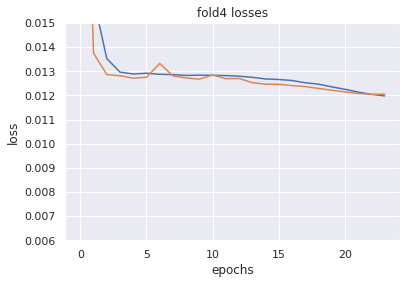

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65322, train_metric: 0.65315
valid_loss: 0.30516, valid_metric: 0.30464
-----EPOCH2-----
train_loss: 0.06717, train_metric: 0.06539
valid_loss: 0.02245, valid_metric: 0.01998
-----EPOCH3-----
train_loss: 0.02109, train_metric: 0.01837
valid_loss: 0.02021, valid_metric: 0.01733
-----EPOCH4-----
train_loss: 0.01998, train_metric: 0.01699
valid_loss: 0.01991, valid_metric: 0.01688
-----EPOCH5-----
train_loss: 0.02191, train_metric: 0.01874
valid_loss: 0.01995, valid_metric: 0.01665
-----EPOCH6-----
train_loss: 0.01977, train_metric: 0.01655
valid_loss: 0.01991, valid_metric: 0.01670
-----EPOCH7-----
train_loss: 0.01962, train_metric: 0.01640
valid_loss: 0.01981, valid_metric: 0.01655
-----EPOCH8-----
train_loss: 0.01956, train_metric: 0.01633
valid_loss: 0.01968, valid_metric: 0.01643
-----EPOCH9-----
train_loss: 0.01979, train_metric: 0.01654
valid_loss: 0.01971, valid_metric: 0.01644
-----EPOCH10-----
train_loss: 0.01948, train_metric: 0.01

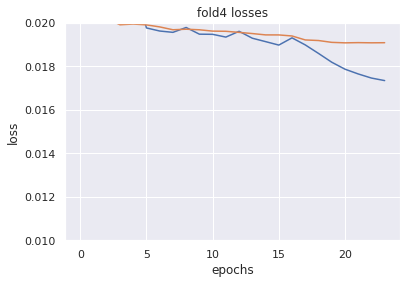

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51046, train_metric: 0.51004
valid_loss: 0.02641, valid_metric: 0.02413
-----EPOCH2-----
train_loss: 0.01651, train_metric: 0.01366
valid_loss: 0.01572, valid_metric: 0.01282
-----EPOCH3-----
train_loss: 0.01359, train_metric: 0.01024
valid_loss: 0.01293, valid_metric: 0.00964
-----EPOCH4-----
train_loss: 0.01306, train_metric: 0.00974
valid_loss: 0.01309, valid_metric: 0.00988
-----EPOCH5-----
train_loss: 0.01286, train_metric: 0.00953
valid_loss: 0.01296, valid_metric: 0.00962
-----EPOCH6-----
train_loss: 0.01303, train_metric: 0.00970
valid_loss: 0.01278, valid_metric: 0.00953
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00958
valid_loss: 0.01288, valid_metric: 0.00962
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00963
valid_loss: 0.01273, valid_metric: 0.00950
-----EPOCH9-----
train_loss: 0.01287, train_metric: 0.00961
valid_loss: 0.01368, valid_metric: 0.01037
-----EPOCH10-----
train_loss: 0

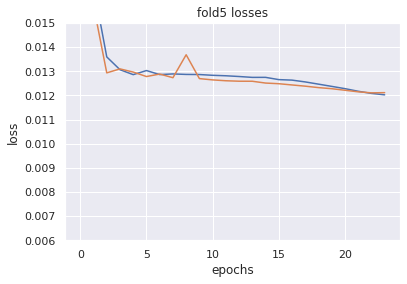

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65603, train_metric: 0.65596
valid_loss: 0.30637, valid_metric: 0.30584
-----EPOCH2-----
train_loss: 0.06732, train_metric: 0.06554
valid_loss: 0.02282, valid_metric: 0.02038
-----EPOCH3-----
train_loss: 0.02125, train_metric: 0.01854
valid_loss: 0.02039, valid_metric: 0.01752
-----EPOCH4-----
train_loss: 0.02001, train_metric: 0.01704
valid_loss: 0.02009, valid_metric: 0.01705
-----EPOCH5-----
train_loss: 0.02321, train_metric: 0.02003
valid_loss: 0.02029, valid_metric: 0.01693
-----EPOCH6-----
train_loss: 0.01976, train_metric: 0.01655
valid_loss: 0.02003, valid_metric: 0.01680
-----EPOCH7-----
train_loss: 0.01960, train_metric: 0.01637
valid_loss: 0.02006, valid_metric: 0.01674
-----EPOCH8-----
train_loss: 0.01958, train_metric: 0.01635
valid_loss: 0.01996, valid_metric: 0.01672
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01657
valid_loss: 0.02014, valid_metric: 0.01683
-----EPOCH10-----
train_loss: 0.01959, train_metric: 0.01

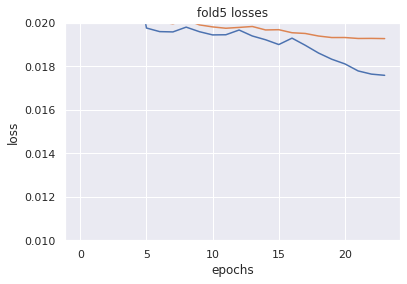

 
SEED : 5

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50968, train_metric: 0.50925
valid_loss: 0.02552, valid_metric: 0.02333
-----EPOCH2-----
train_loss: 0.01605, train_metric: 0.01320
valid_loss: 0.01372, valid_metric: 0.01052
-----EPOCH3-----
train_loss: 0.01344, train_metric: 0.01020
valid_loss: 0.01315, valid_metric: 0.00993
-----EPOCH4-----
train_loss: 0.01310, train_metric: 0.00979
valid_loss: 0.01395, valid_metric: 0.01067
-----EPOCH5-----
train_loss: 0.01297, train_metric: 0.00965
valid_loss: 0.01288, valid_metric: 0.00962
-----EPOCH6-----
train_loss: 0.01296, train_metric: 0.00967
valid_loss: 0.01287, valid_metric: 0.00958
-----EPOCH7-----
train_loss: 0.01292, train_metric: 0.00964
valid_loss: 0.01270, valid_metric: 0.00948
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00963
valid_loss: 0.01281, valid_metric: 0.00959
-----EPOCH9-----
train_loss: 0.01288, train_metric: 0.00962
valid_loss: 0.01365, valid_metric: 0.01034
-----EPOCH10-----
t

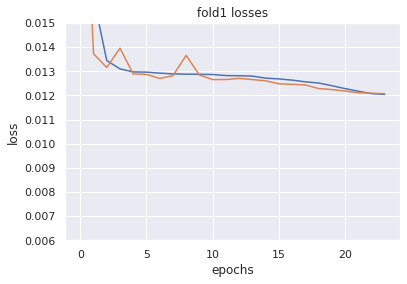

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65068, train_metric: 0.65060
valid_loss: 0.30303, valid_metric: 0.30249
-----EPOCH2-----
train_loss: 0.06700, train_metric: 0.06523
valid_loss: 0.02258, valid_metric: 0.02011
-----EPOCH3-----
train_loss: 0.02121, train_metric: 0.01849
valid_loss: 0.02037, valid_metric: 0.01748
-----EPOCH4-----
train_loss: 0.02012, train_metric: 0.01714
valid_loss: 0.02003, valid_metric: 0.01698
-----EPOCH5-----
train_loss: 0.02369, train_metric: 0.02054
valid_loss: 0.02018, valid_metric: 0.01683
-----EPOCH6-----
train_loss: 0.01983, train_metric: 0.01664
valid_loss: 0.01996, valid_metric: 0.01664
-----EPOCH7-----
train_loss: 0.01974, train_metric: 0.01652
valid_loss: 0.01989, valid_metric: 0.01665
-----EPOCH8-----
train_loss: 0.01962, train_metric: 0.01639
valid_loss: 0.01987, valid_metric: 0.01657
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01657
valid_loss: 0.01995, valid_metric: 0.01658
-----EPOCH10-----
train_loss: 0.01960, train_metric: 0.01

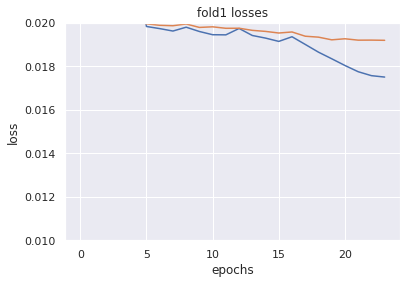

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50856, train_metric: 0.50813
valid_loss: 0.02492, valid_metric: 0.02251
-----EPOCH2-----
train_loss: 0.01575, train_metric: 0.01291
valid_loss: 0.01364, valid_metric: 0.01055
-----EPOCH3-----
train_loss: 0.01349, train_metric: 0.01026
valid_loss: 0.01340, valid_metric: 0.01012
-----EPOCH4-----
train_loss: 0.01340, train_metric: 0.01005
valid_loss: 0.01310, valid_metric: 0.00973
-----EPOCH5-----
train_loss: 0.01292, train_metric: 0.00958
valid_loss: 0.01300, valid_metric: 0.00972
-----EPOCH6-----
train_loss: 0.01282, train_metric: 0.00953
valid_loss: 0.01275, valid_metric: 0.00947
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00959
valid_loss: 0.01320, valid_metric: 0.00990
-----EPOCH8-----
train_loss: 0.01288, train_metric: 0.00962
valid_loss: 0.01381, valid_metric: 0.01056
-----EPOCH9-----
train_loss: 0.01280, train_metric: 0.00956
valid_loss: 0.01289, valid_metric: 0.00968
-----EPOCH10-----
train_loss: 0

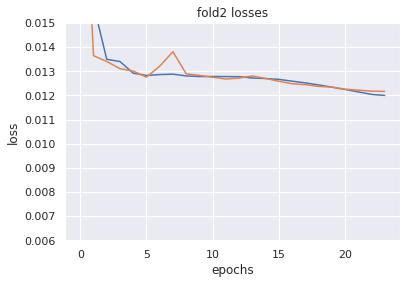

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65239, train_metric: 0.65232
valid_loss: 0.30679, valid_metric: 0.30626
-----EPOCH2-----
train_loss: 0.06794, train_metric: 0.06616
valid_loss: 0.02238, valid_metric: 0.01991
-----EPOCH3-----
train_loss: 0.02113, train_metric: 0.01842
valid_loss: 0.02018, valid_metric: 0.01730
-----EPOCH4-----
train_loss: 0.02006, train_metric: 0.01709
valid_loss: 0.01988, valid_metric: 0.01685
-----EPOCH5-----
train_loss: 0.02403, train_metric: 0.02089
valid_loss: 0.02001, valid_metric: 0.01675
-----EPOCH6-----
train_loss: 0.01989, train_metric: 0.01669
valid_loss: 0.01984, valid_metric: 0.01658
-----EPOCH7-----
train_loss: 0.01967, train_metric: 0.01645
valid_loss: 0.01984, valid_metric: 0.01658
-----EPOCH8-----
train_loss: 0.01958, train_metric: 0.01635
valid_loss: 0.01986, valid_metric: 0.01663
-----EPOCH9-----
train_loss: 0.01981, train_metric: 0.01658
valid_loss: 0.01981, valid_metric: 0.01654
-----EPOCH10-----
train_loss: 0.01956, train_metric: 0.01

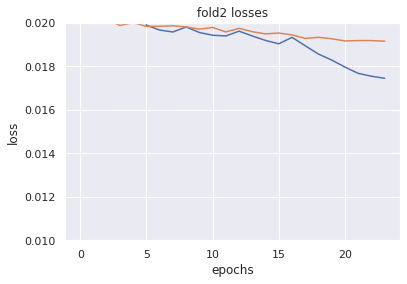

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50912, train_metric: 0.50869
valid_loss: 0.02535, valid_metric: 0.02299
-----EPOCH2-----
train_loss: 0.01620, train_metric: 0.01334
valid_loss: 0.01418, valid_metric: 0.01108
-----EPOCH3-----
train_loss: 0.01375, train_metric: 0.01048
valid_loss: 0.01290, valid_metric: 0.00957
-----EPOCH4-----
train_loss: 0.01298, train_metric: 0.00964
valid_loss: 0.01289, valid_metric: 0.00966
-----EPOCH5-----
train_loss: 0.01292, train_metric: 0.00961
valid_loss: 0.01304, valid_metric: 0.00972
-----EPOCH6-----
train_loss: 0.01305, train_metric: 0.00974
valid_loss: 0.01314, valid_metric: 0.00962
-----EPOCH7-----
train_loss: 0.01299, train_metric: 0.00967
valid_loss: 0.01476, valid_metric: 0.01150
-----EPOCH8-----
train_loss: 0.01293, train_metric: 0.00967
valid_loss: 0.01276, valid_metric: 0.00953
-----EPOCH9-----
train_loss: 0.01290, train_metric: 0.00964
valid_loss: 0.01275, valid_metric: 0.00948
-----EPOCH10-----
train_loss: 0

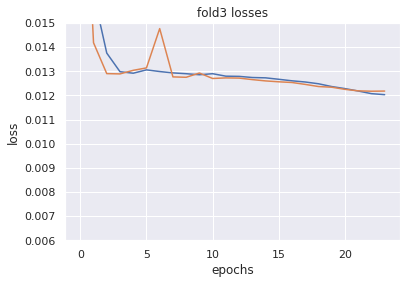

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65340, train_metric: 0.65332
valid_loss: 0.30713, valid_metric: 0.30661
-----EPOCH2-----
train_loss: 0.06716, train_metric: 0.06538
valid_loss: 0.02260, valid_metric: 0.02013
-----EPOCH3-----
train_loss: 0.02124, train_metric: 0.01853
valid_loss: 0.02033, valid_metric: 0.01746
-----EPOCH4-----
train_loss: 0.02010, train_metric: 0.01713
valid_loss: 0.02015, valid_metric: 0.01713
-----EPOCH5-----
train_loss: 0.02183, train_metric: 0.01868
valid_loss: 0.02025, valid_metric: 0.01690
-----EPOCH6-----
train_loss: 0.01997, train_metric: 0.01677
valid_loss: 0.02003, valid_metric: 0.01685
-----EPOCH7-----
train_loss: 0.01986, train_metric: 0.01663
valid_loss: 0.02001, valid_metric: 0.01669
-----EPOCH8-----
train_loss: 0.01972, train_metric: 0.01648
valid_loss: 0.01992, valid_metric: 0.01664
-----EPOCH9-----
train_loss: 0.02000, train_metric: 0.01677
valid_loss: 0.02003, valid_metric: 0.01672
-----EPOCH10-----
train_loss: 0.01973, train_metric: 0.01

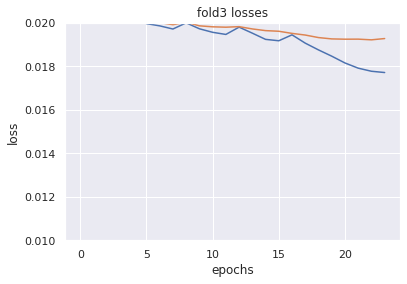

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50871, train_metric: 0.50827
valid_loss: 0.02955, valid_metric: 0.02707
-----EPOCH2-----
train_loss: 0.01583, train_metric: 0.01297
valid_loss: 0.01383, valid_metric: 0.01075
-----EPOCH3-----
train_loss: 0.01380, train_metric: 0.01051
valid_loss: 0.01293, valid_metric: 0.00963
-----EPOCH4-----
train_loss: 0.01306, train_metric: 0.00975
valid_loss: 0.01270, valid_metric: 0.00940
-----EPOCH5-----
train_loss: 0.01303, train_metric: 0.00972
valid_loss: 0.01428, valid_metric: 0.01079
-----EPOCH6-----
train_loss: 0.01296, train_metric: 0.00965
valid_loss: 0.01351, valid_metric: 0.01029
-----EPOCH7-----
train_loss: 0.01293, train_metric: 0.00965
valid_loss: 0.01291, valid_metric: 0.00956
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00960
valid_loss: 0.01269, valid_metric: 0.00942
-----EPOCH9-----
train_loss: 0.01288, train_metric: 0.00964
valid_loss: 0.01286, valid_metric: 0.00967
-----EPOCH10-----
train_loss: 0

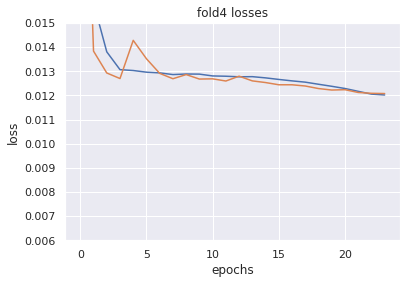

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65454, train_metric: 0.65447
valid_loss: 0.30984, valid_metric: 0.30932
-----EPOCH2-----
train_loss: 0.06759, train_metric: 0.06581
valid_loss: 0.02246, valid_metric: 0.01999
-----EPOCH3-----
train_loss: 0.02120, train_metric: 0.01848
valid_loss: 0.02018, valid_metric: 0.01729
-----EPOCH4-----
train_loss: 0.02010, train_metric: 0.01712
valid_loss: 0.01992, valid_metric: 0.01689
-----EPOCH5-----
train_loss: 0.02414, train_metric: 0.02101
valid_loss: 0.02005, valid_metric: 0.01676
-----EPOCH6-----
train_loss: 0.01986, train_metric: 0.01666
valid_loss: 0.01983, valid_metric: 0.01659
-----EPOCH7-----
train_loss: 0.01964, train_metric: 0.01641
valid_loss: 0.01989, valid_metric: 0.01660
-----EPOCH8-----
train_loss: 0.01962, train_metric: 0.01639
valid_loss: 0.01972, valid_metric: 0.01647
-----EPOCH9-----
train_loss: 0.01984, train_metric: 0.01660
valid_loss: 0.01979, valid_metric: 0.01652
-----EPOCH10-----
train_loss: 0.01951, train_metric: 0.01

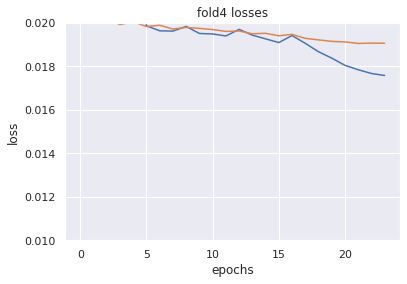

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50943, train_metric: 0.50901
valid_loss: 0.02450, valid_metric: 0.02223
-----EPOCH2-----
train_loss: 0.01617, train_metric: 0.01333
valid_loss: 0.01372, valid_metric: 0.01045
-----EPOCH3-----
train_loss: 0.01344, train_metric: 0.01014
valid_loss: 0.01333, valid_metric: 0.01004
-----EPOCH4-----
train_loss: 0.01305, train_metric: 0.00976
valid_loss: 0.01507, valid_metric: 0.01180
-----EPOCH5-----
train_loss: 0.01309, train_metric: 0.00978
valid_loss: 0.01283, valid_metric: 0.00957
-----EPOCH6-----
train_loss: 0.01287, train_metric: 0.00958
valid_loss: 0.01303, valid_metric: 0.00976
-----EPOCH7-----
train_loss: 0.01303, train_metric: 0.00975
valid_loss: 0.01274, valid_metric: 0.00950
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00960
valid_loss: 0.01290, valid_metric: 0.00969
-----EPOCH9-----
train_loss: 0.01289, train_metric: 0.00965
valid_loss: 0.01276, valid_metric: 0.00954
-----EPOCH10-----
train_loss: 0

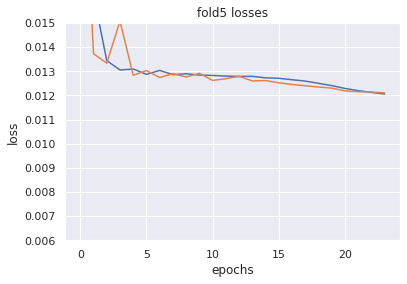

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65193, train_metric: 0.65186
valid_loss: 0.31155, valid_metric: 0.31104
-----EPOCH2-----
train_loss: 0.06772, train_metric: 0.06594
valid_loss: 0.02278, valid_metric: 0.02032
-----EPOCH3-----
train_loss: 0.02126, train_metric: 0.01854
valid_loss: 0.02042, valid_metric: 0.01754
-----EPOCH4-----
train_loss: 0.02014, train_metric: 0.01716
valid_loss: 0.02013, valid_metric: 0.01710
-----EPOCH5-----
train_loss: 0.02272, train_metric: 0.01956
valid_loss: 0.02028, valid_metric: 0.01694
-----EPOCH6-----
train_loss: 0.01989, train_metric: 0.01668
valid_loss: 0.02009, valid_metric: 0.01674
-----EPOCH7-----
train_loss: 0.01975, train_metric: 0.01653
valid_loss: 0.02001, valid_metric: 0.01672
-----EPOCH8-----
train_loss: 0.01966, train_metric: 0.01644
valid_loss: 0.01998, valid_metric: 0.01677
-----EPOCH9-----
train_loss: 0.01989, train_metric: 0.01666
valid_loss: 0.02004, valid_metric: 0.01671
-----EPOCH10-----
train_loss: 0.01972, train_metric: 0.01

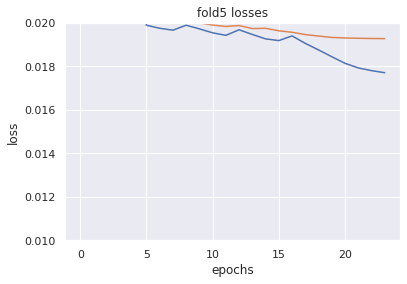

 
SEED : 6

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50823, train_metric: 0.50779
valid_loss: 0.02472, valid_metric: 0.02231
-----EPOCH2-----
train_loss: 0.01588, train_metric: 0.01305
valid_loss: 0.01390, valid_metric: 0.01073
-----EPOCH3-----
train_loss: 0.01339, train_metric: 0.01018
valid_loss: 0.01299, valid_metric: 0.00980
-----EPOCH4-----
train_loss: 0.01299, train_metric: 0.00971
valid_loss: 0.01296, valid_metric: 0.00970
-----EPOCH5-----
train_loss: 0.01299, train_metric: 0.00968
valid_loss: 0.01271, valid_metric: 0.00943
-----EPOCH6-----
train_loss: 0.01297, train_metric: 0.00967
valid_loss: 0.01290, valid_metric: 0.00963
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00959
valid_loss: 0.01291, valid_metric: 0.00963
-----EPOCH8-----
train_loss: 0.01287, train_metric: 0.00962
valid_loss: 0.01337, valid_metric: 0.01013
-----EPOCH9-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01275, valid_metric: 0.00954
-----EPOCH10-----
t

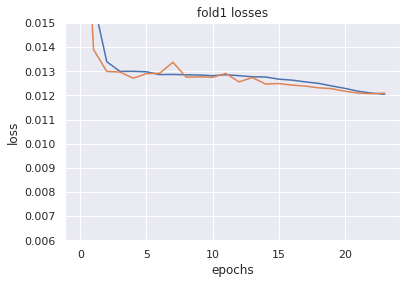

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65077, train_metric: 0.65069
valid_loss: 0.30338, valid_metric: 0.30285
-----EPOCH2-----
train_loss: 0.06693, train_metric: 0.06515
valid_loss: 0.02258, valid_metric: 0.02011
-----EPOCH3-----
train_loss: 0.02125, train_metric: 0.01854
valid_loss: 0.02029, valid_metric: 0.01743
-----EPOCH4-----
train_loss: 0.02018, train_metric: 0.01721
valid_loss: 0.02002, valid_metric: 0.01698
-----EPOCH5-----
train_loss: 0.02280, train_metric: 0.01963
valid_loss: 0.02012, valid_metric: 0.01679
-----EPOCH6-----
train_loss: 0.01990, train_metric: 0.01668
valid_loss: 0.02002, valid_metric: 0.01668
-----EPOCH7-----
train_loss: 0.01981, train_metric: 0.01659
valid_loss: 0.01997, valid_metric: 0.01666
-----EPOCH8-----
train_loss: 0.01963, train_metric: 0.01640
valid_loss: 0.01986, valid_metric: 0.01656
-----EPOCH9-----
train_loss: 0.01986, train_metric: 0.01663
valid_loss: 0.01990, valid_metric: 0.01664
-----EPOCH10-----
train_loss: 0.01967, train_metric: 0.01

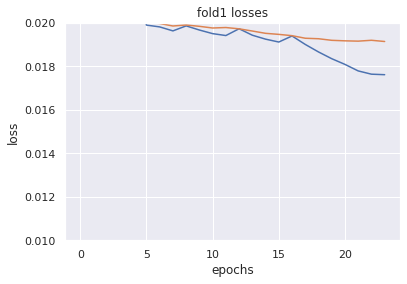

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50877, train_metric: 0.50834
valid_loss: 0.02530, valid_metric: 0.02300
-----EPOCH2-----
train_loss: 0.01601, train_metric: 0.01317
valid_loss: 0.01420, valid_metric: 0.01103
-----EPOCH3-----
train_loss: 0.01340, train_metric: 0.01016
valid_loss: 0.01439, valid_metric: 0.01118
-----EPOCH4-----
train_loss: 0.01309, train_metric: 0.00981
valid_loss: 0.01309, valid_metric: 0.00974
-----EPOCH5-----
train_loss: 0.01331, train_metric: 0.00994
valid_loss: 0.01409, valid_metric: 0.01078
-----EPOCH6-----
train_loss: 0.01286, train_metric: 0.00954
valid_loss: 0.01285, valid_metric: 0.00956
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00959
valid_loss: 0.01646, valid_metric: 0.01329
-----EPOCH8-----
train_loss: 0.01291, train_metric: 0.00965
valid_loss: 0.01291, valid_metric: 0.00965
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00957
valid_loss: 0.01271, valid_metric: 0.00942
-----EPOCH10-----
train_loss: 0

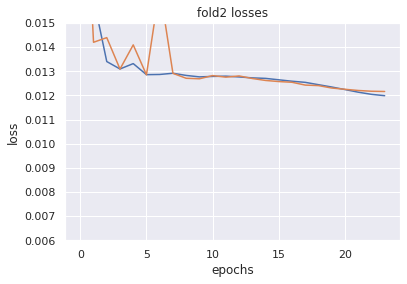

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65348, train_metric: 0.65341
valid_loss: 0.30875, valid_metric: 0.30823
-----EPOCH2-----
train_loss: 0.06713, train_metric: 0.06534
valid_loss: 0.02259, valid_metric: 0.02014
-----EPOCH3-----
train_loss: 0.02117, train_metric: 0.01845
valid_loss: 0.02021, valid_metric: 0.01734
-----EPOCH4-----
train_loss: 0.02002, train_metric: 0.01704
valid_loss: 0.01992, valid_metric: 0.01689
-----EPOCH5-----
train_loss: 0.02176, train_metric: 0.01863
valid_loss: 0.02005, valid_metric: 0.01680
-----EPOCH6-----
train_loss: 0.01983, train_metric: 0.01663
valid_loss: 0.01994, valid_metric: 0.01672
-----EPOCH7-----
train_loss: 0.01968, train_metric: 0.01645
valid_loss: 0.01980, valid_metric: 0.01653
-----EPOCH8-----
train_loss: 0.01955, train_metric: 0.01632
valid_loss: 0.01973, valid_metric: 0.01646
-----EPOCH9-----
train_loss: 0.01978, train_metric: 0.01655
valid_loss: 0.01984, valid_metric: 0.01659
-----EPOCH10-----
train_loss: 0.01952, train_metric: 0.01

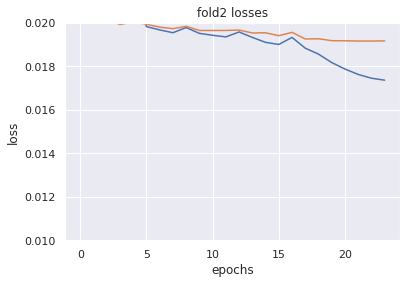

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50851, train_metric: 0.50808
valid_loss: 0.02771, valid_metric: 0.02563
-----EPOCH2-----
train_loss: 0.01640, train_metric: 0.01352
valid_loss: 0.01428, valid_metric: 0.01115
-----EPOCH3-----
train_loss: 0.01349, train_metric: 0.01025
valid_loss: 0.01289, valid_metric: 0.00962
-----EPOCH4-----
train_loss: 0.01312, train_metric: 0.00983
valid_loss: 0.01553, valid_metric: 0.01234
-----EPOCH5-----
train_loss: 0.01311, train_metric: 0.00974
valid_loss: 0.01322, valid_metric: 0.00993
-----EPOCH6-----
train_loss: 0.01285, train_metric: 0.00953
valid_loss: 0.01272, valid_metric: 0.00942
-----EPOCH7-----
train_loss: 0.01283, train_metric: 0.00955
valid_loss: 0.01275, valid_metric: 0.00948
-----EPOCH8-----
train_loss: 0.01283, train_metric: 0.00957
valid_loss: 0.01272, valid_metric: 0.00943
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00958
valid_loss: 0.01272, valid_metric: 0.00947
-----EPOCH10-----
train_loss: 0

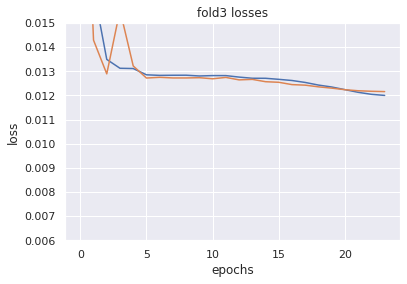

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65329, train_metric: 0.65322
valid_loss: 0.30143, valid_metric: 0.30089
-----EPOCH2-----
train_loss: 0.06645, train_metric: 0.06467
valid_loss: 0.02268, valid_metric: 0.02022
-----EPOCH3-----
train_loss: 0.02122, train_metric: 0.01852
valid_loss: 0.02036, valid_metric: 0.01750
-----EPOCH4-----
train_loss: 0.02003, train_metric: 0.01707
valid_loss: 0.02008, valid_metric: 0.01706
-----EPOCH5-----
train_loss: 0.02274, train_metric: 0.01959
valid_loss: 0.02017, valid_metric: 0.01693
-----EPOCH6-----
train_loss: 0.01991, train_metric: 0.01671
valid_loss: 0.02003, valid_metric: 0.01673
-----EPOCH7-----
train_loss: 0.01963, train_metric: 0.01642
valid_loss: 0.02004, valid_metric: 0.01670
-----EPOCH8-----
train_loss: 0.01951, train_metric: 0.01629
valid_loss: 0.01988, valid_metric: 0.01659
-----EPOCH9-----
train_loss: 0.01971, train_metric: 0.01648
valid_loss: 0.01994, valid_metric: 0.01666
-----EPOCH10-----
train_loss: 0.01953, train_metric: 0.01

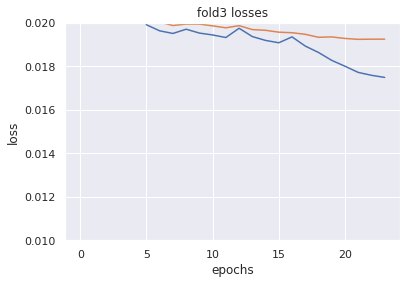

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50808, train_metric: 0.50765
valid_loss: 0.05752, valid_metric: 0.05557
-----EPOCH2-----
train_loss: 0.01589, train_metric: 0.01305
valid_loss: 0.01408, valid_metric: 0.01108
-----EPOCH3-----
train_loss: 0.01360, train_metric: 0.01035
valid_loss: 0.05194, valid_metric: 0.04888
-----EPOCH4-----
train_loss: 0.01311, train_metric: 0.00978
valid_loss: 0.01335, valid_metric: 0.01007
-----EPOCH5-----
train_loss: 0.01303, train_metric: 0.00973
valid_loss: 0.01283, valid_metric: 0.00954
-----EPOCH6-----
train_loss: 0.01283, train_metric: 0.00953
valid_loss: 0.01275, valid_metric: 0.00947
-----EPOCH7-----
train_loss: 0.01287, train_metric: 0.00960
valid_loss: 0.01276, valid_metric: 0.00944
-----EPOCH8-----
train_loss: 0.01287, train_metric: 0.00961
valid_loss: 0.01289, valid_metric: 0.00967
-----EPOCH9-----
train_loss: 0.01286, train_metric: 0.00960
valid_loss: 0.01266, valid_metric: 0.00942
-----EPOCH10-----
train_loss: 0

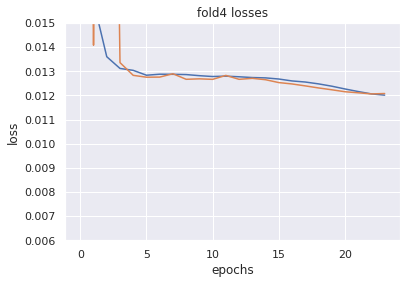

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65228, train_metric: 0.65220
valid_loss: 0.30378, valid_metric: 0.30325
-----EPOCH2-----
train_loss: 0.06704, train_metric: 0.06526
valid_loss: 0.02248, valid_metric: 0.02001
-----EPOCH3-----
train_loss: 0.02126, train_metric: 0.01855
valid_loss: 0.02019, valid_metric: 0.01730
-----EPOCH4-----
train_loss: 0.02005, train_metric: 0.01708
valid_loss: 0.01988, valid_metric: 0.01685
-----EPOCH5-----
train_loss: 0.02201, train_metric: 0.01885
valid_loss: 0.02005, valid_metric: 0.01674
-----EPOCH6-----
train_loss: 0.01984, train_metric: 0.01663
valid_loss: 0.01984, valid_metric: 0.01657
-----EPOCH7-----
train_loss: 0.01966, train_metric: 0.01644
valid_loss: 0.01978, valid_metric: 0.01652
-----EPOCH8-----
train_loss: 0.01953, train_metric: 0.01630
valid_loss: 0.01972, valid_metric: 0.01643
-----EPOCH9-----
train_loss: 0.01975, train_metric: 0.01652
valid_loss: 0.01995, valid_metric: 0.01654
-----EPOCH10-----
train_loss: 0.01953, train_metric: 0.01

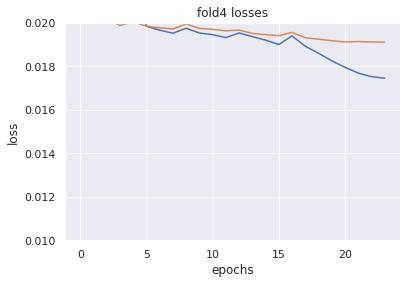

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50845, train_metric: 0.50802
valid_loss: 0.02933, valid_metric: 0.02715
-----EPOCH2-----
train_loss: 0.01674, train_metric: 0.01389
valid_loss: 0.01488, valid_metric: 0.01169
-----EPOCH3-----
train_loss: 0.01358, train_metric: 0.01019
valid_loss: 0.01291, valid_metric: 0.00960
-----EPOCH4-----
train_loss: 0.01301, train_metric: 0.00969
valid_loss: 0.01272, valid_metric: 0.00942
-----EPOCH5-----
train_loss: 0.01297, train_metric: 0.00966
valid_loss: 0.01610, valid_metric: 0.01281
-----EPOCH6-----
train_loss: 0.01298, train_metric: 0.00969
valid_loss: 0.01278, valid_metric: 0.00954
-----EPOCH7-----
train_loss: 0.01298, train_metric: 0.00971
valid_loss: 0.01375, valid_metric: 0.01049
-----EPOCH8-----
train_loss: 0.01291, train_metric: 0.00965
valid_loss: 0.01273, valid_metric: 0.00949
-----EPOCH9-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01274, valid_metric: 0.00948
-----EPOCH10-----
train_loss: 0

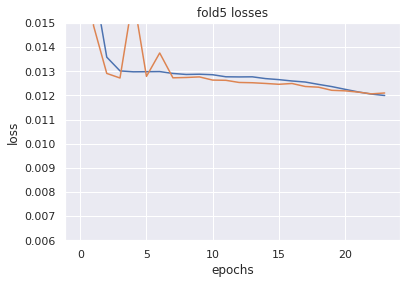

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65632, train_metric: 0.65625
valid_loss: 0.30880, valid_metric: 0.30828
-----EPOCH2-----
train_loss: 0.06764, train_metric: 0.06586
valid_loss: 0.02254, valid_metric: 0.02008
-----EPOCH3-----
train_loss: 0.02114, train_metric: 0.01843
valid_loss: 0.02032, valid_metric: 0.01745
-----EPOCH4-----
train_loss: 0.02000, train_metric: 0.01702
valid_loss: 0.02011, valid_metric: 0.01708
-----EPOCH5-----
train_loss: 0.02273, train_metric: 0.01956
valid_loss: 0.02018, valid_metric: 0.01683
-----EPOCH6-----
train_loss: 0.01981, train_metric: 0.01659
valid_loss: 0.02001, valid_metric: 0.01673
-----EPOCH7-----
train_loss: 0.01963, train_metric: 0.01640
valid_loss: 0.01999, valid_metric: 0.01667
-----EPOCH8-----
train_loss: 0.01950, train_metric: 0.01627
valid_loss: 0.01985, valid_metric: 0.01665
-----EPOCH9-----
train_loss: 0.01976, train_metric: 0.01652
valid_loss: 0.01999, valid_metric: 0.01676
-----EPOCH10-----
train_loss: 0.01957, train_metric: 0.01

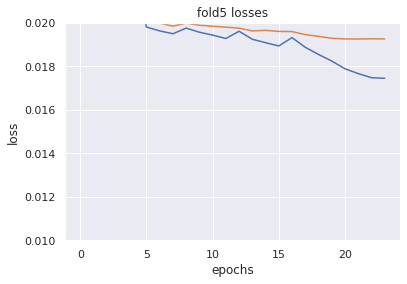

 
SEED : 7

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50747, train_metric: 0.50704
valid_loss: 0.02666, valid_metric: 0.02449
-----EPOCH2-----
train_loss: 0.01585, train_metric: 0.01303
valid_loss: 0.01397, valid_metric: 0.01083
-----EPOCH3-----
train_loss: 0.01339, train_metric: 0.01015
valid_loss: 0.01382, valid_metric: 0.01064
-----EPOCH4-----
train_loss: 0.01335, train_metric: 0.01003
valid_loss: 0.01423, valid_metric: 0.01089
-----EPOCH5-----
train_loss: 0.01438, train_metric: 0.01096
valid_loss: 0.01378, valid_metric: 0.01035
-----EPOCH6-----
train_loss: 0.01325, train_metric: 0.00991
valid_loss: 0.01300, valid_metric: 0.00970
-----EPOCH7-----
train_loss: 0.01300, train_metric: 0.00973
valid_loss: 0.01301, valid_metric: 0.00977
-----EPOCH8-----
train_loss: 0.01300, train_metric: 0.00975
valid_loss: 0.01291, valid_metric: 0.00968
-----EPOCH9-----
train_loss: 0.01298, train_metric: 0.00974
valid_loss: 0.01288, valid_metric: 0.00967
-----EPOCH10-----
t

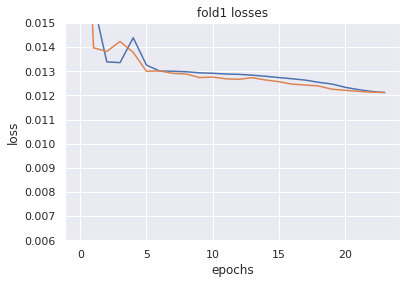

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.66165, train_metric: 0.66158
valid_loss: 0.32445, valid_metric: 0.32396
-----EPOCH2-----
train_loss: 0.06939, train_metric: 0.06762
valid_loss: 0.02295, valid_metric: 0.02051
-----EPOCH3-----
train_loss: 0.02146, train_metric: 0.01876
valid_loss: 0.02047, valid_metric: 0.01761
-----EPOCH4-----
train_loss: 0.02041, train_metric: 0.01744
valid_loss: 0.02008, valid_metric: 0.01704
-----EPOCH5-----
train_loss: 0.02214, train_metric: 0.01895
valid_loss: 0.02023, valid_metric: 0.01690
-----EPOCH6-----
train_loss: 0.02006, train_metric: 0.01683
valid_loss: 0.02003, valid_metric: 0.01683
-----EPOCH7-----
train_loss: 0.01988, train_metric: 0.01665
valid_loss: 0.01993, valid_metric: 0.01666
-----EPOCH8-----
train_loss: 0.01983, train_metric: 0.01659
valid_loss: 0.01990, valid_metric: 0.01668
-----EPOCH9-----
train_loss: 0.02003, train_metric: 0.01679
valid_loss: 0.01987, valid_metric: 0.01659
-----EPOCH10-----
train_loss: 0.01976, train_metric: 0.01

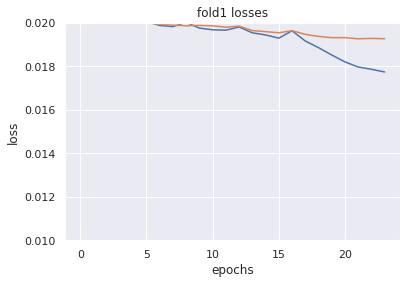

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50836, train_metric: 0.50793
valid_loss: 0.02767, valid_metric: 0.02537
-----EPOCH2-----
train_loss: 0.01578, train_metric: 0.01296
valid_loss: 0.01358, valid_metric: 0.01050
-----EPOCH3-----
train_loss: 0.01333, train_metric: 0.01011
valid_loss: 0.01384, valid_metric: 0.01061
-----EPOCH4-----
train_loss: 0.01342, train_metric: 0.01007
valid_loss: 0.01420, valid_metric: 0.01083
-----EPOCH5-----
train_loss: 0.01296, train_metric: 0.00962
valid_loss: 0.01280, valid_metric: 0.00951
-----EPOCH6-----
train_loss: 0.01279, train_metric: 0.00951
valid_loss: 0.01283, valid_metric: 0.00963
-----EPOCH7-----
train_loss: 0.01281, train_metric: 0.00955
valid_loss: 0.01297, valid_metric: 0.00977
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01285, valid_metric: 0.00966
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00958
valid_loss: 0.01291, valid_metric: 0.00963
-----EPOCH10-----
train_loss: 0

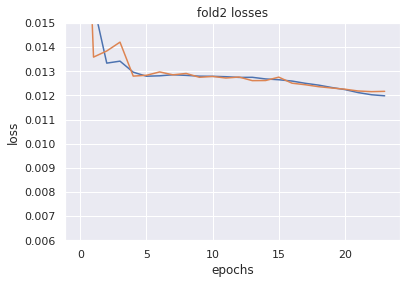

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65288, train_metric: 0.65280
valid_loss: 0.31084, valid_metric: 0.31033
-----EPOCH2-----
train_loss: 0.06827, train_metric: 0.06650
valid_loss: 0.02262, valid_metric: 0.02017
-----EPOCH3-----
train_loss: 0.02111, train_metric: 0.01840
valid_loss: 0.02016, valid_metric: 0.01728
-----EPOCH4-----
train_loss: 0.02001, train_metric: 0.01704
valid_loss: 0.01988, valid_metric: 0.01686
-----EPOCH5-----
train_loss: 0.02152, train_metric: 0.01835
valid_loss: 0.01988, valid_metric: 0.01667
-----EPOCH6-----
train_loss: 0.01975, train_metric: 0.01654
valid_loss: 0.01978, valid_metric: 0.01650
-----EPOCH7-----
train_loss: 0.01971, train_metric: 0.01649
valid_loss: 0.01981, valid_metric: 0.01648
-----EPOCH8-----
train_loss: 0.01961, train_metric: 0.01639
valid_loss: 0.01972, valid_metric: 0.01642
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01656
valid_loss: 0.01992, valid_metric: 0.01661
-----EPOCH10-----
train_loss: 0.01948, train_metric: 0.01

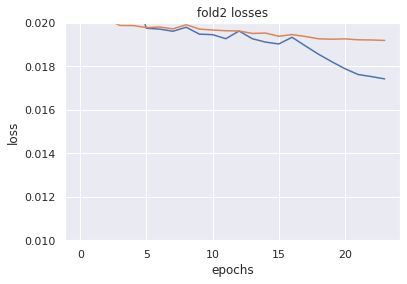

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51012, train_metric: 0.50969
valid_loss: 0.02705, valid_metric: 0.02490
-----EPOCH2-----
train_loss: 0.01604, train_metric: 0.01320
valid_loss: 0.01542, valid_metric: 0.01235
-----EPOCH3-----
train_loss: 0.01353, train_metric: 0.01026
valid_loss: 0.01292, valid_metric: 0.00968
-----EPOCH4-----
train_loss: 0.01305, train_metric: 0.00976
valid_loss: 0.01284, valid_metric: 0.00955
-----EPOCH5-----
train_loss: 0.01311, train_metric: 0.00977
valid_loss: 0.01273, valid_metric: 0.00940
-----EPOCH6-----
train_loss: 0.01290, train_metric: 0.00960
valid_loss: 0.01352, valid_metric: 0.01027
-----EPOCH7-----
train_loss: 0.01291, train_metric: 0.00964
valid_loss: 0.01282, valid_metric: 0.00955
-----EPOCH8-----
train_loss: 0.01288, train_metric: 0.00963
valid_loss: 0.01276, valid_metric: 0.00949
-----EPOCH9-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01274, valid_metric: 0.00945
-----EPOCH10-----
train_loss: 0

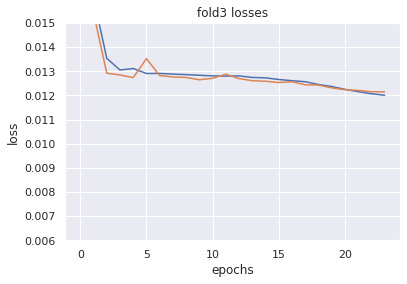

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65363, train_metric: 0.65356
valid_loss: 0.31251, valid_metric: 0.31199
-----EPOCH2-----
train_loss: 0.06779, train_metric: 0.06602
valid_loss: 0.02276, valid_metric: 0.02032
-----EPOCH3-----
train_loss: 0.02123, train_metric: 0.01852
valid_loss: 0.02040, valid_metric: 0.01753
-----EPOCH4-----
train_loss: 0.02010, train_metric: 0.01713
valid_loss: 0.02009, valid_metric: 0.01706
-----EPOCH5-----
train_loss: 0.02378, train_metric: 0.02060
valid_loss: 0.02021, valid_metric: 0.01691
-----EPOCH6-----
train_loss: 0.01984, train_metric: 0.01660
valid_loss: 0.01993, valid_metric: 0.01669
-----EPOCH7-----
train_loss: 0.01967, train_metric: 0.01644
valid_loss: 0.01995, valid_metric: 0.01670
-----EPOCH8-----
train_loss: 0.01954, train_metric: 0.01630
valid_loss: 0.01990, valid_metric: 0.01667
-----EPOCH9-----
train_loss: 0.01978, train_metric: 0.01653
valid_loss: 0.02003, valid_metric: 0.01674
-----EPOCH10-----
train_loss: 0.01957, train_metric: 0.01

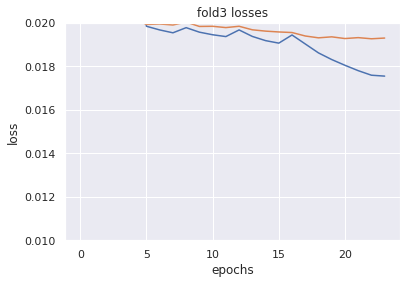

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50932, train_metric: 0.50889
valid_loss: 0.02790, valid_metric: 0.02566
-----EPOCH2-----
train_loss: 0.01620, train_metric: 0.01335
valid_loss: 0.01488, valid_metric: 0.01175
-----EPOCH3-----
train_loss: 0.01344, train_metric: 0.01022
valid_loss: 0.01308, valid_metric: 0.00986
-----EPOCH4-----
train_loss: 0.01300, train_metric: 0.00972
valid_loss: 0.01274, valid_metric: 0.00949
-----EPOCH5-----
train_loss: 0.01295, train_metric: 0.00964
valid_loss: 0.01266, valid_metric: 0.00935
-----EPOCH6-----
train_loss: 0.01294, train_metric: 0.00964
valid_loss: 0.01426, valid_metric: 0.01087
-----EPOCH7-----
train_loss: 0.01289, train_metric: 0.00961
valid_loss: 0.01287, valid_metric: 0.00965
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00963
valid_loss: 0.01272, valid_metric: 0.00947
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00959
valid_loss: 0.01275, valid_metric: 0.00950
-----EPOCH10-----
train_loss: 0

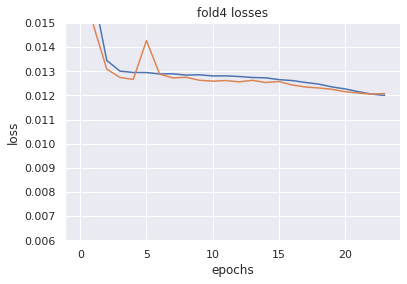

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65381, train_metric: 0.65374
valid_loss: 0.31150, valid_metric: 0.31099
-----EPOCH2-----
train_loss: 0.06786, train_metric: 0.06609
valid_loss: 0.02259, valid_metric: 0.02015
-----EPOCH3-----
train_loss: 0.02114, train_metric: 0.01843
valid_loss: 0.02017, valid_metric: 0.01731
-----EPOCH4-----
train_loss: 0.02011, train_metric: 0.01713
valid_loss: 0.01983, valid_metric: 0.01679
-----EPOCH5-----
train_loss: 0.02430, train_metric: 0.02111
valid_loss: 0.01999, valid_metric: 0.01671
-----EPOCH6-----
train_loss: 0.01970, train_metric: 0.01647
valid_loss: 0.01984, valid_metric: 0.01661
-----EPOCH7-----
train_loss: 0.01965, train_metric: 0.01641
valid_loss: 0.01976, valid_metric: 0.01652
-----EPOCH8-----
train_loss: 0.01945, train_metric: 0.01620
valid_loss: 0.01969, valid_metric: 0.01643
-----EPOCH9-----
train_loss: 0.01972, train_metric: 0.01647
valid_loss: 0.01971, valid_metric: 0.01647
-----EPOCH10-----
train_loss: 0.01950, train_metric: 0.01

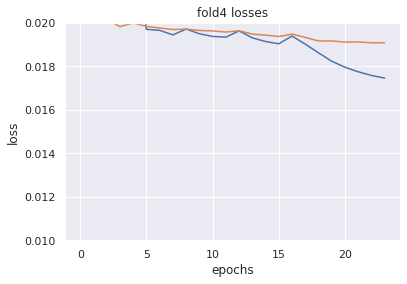

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50885, train_metric: 0.50842
valid_loss: 0.03247, valid_metric: 0.03035
-----EPOCH2-----
train_loss: 0.01600, train_metric: 0.01316
valid_loss: 0.01404, valid_metric: 0.01092
-----EPOCH3-----
train_loss: 0.01341, train_metric: 0.01018
valid_loss: 0.01299, valid_metric: 0.00979
-----EPOCH4-----
train_loss: 0.01299, train_metric: 0.00971
valid_loss: 0.01499, valid_metric: 0.01158
-----EPOCH5-----
train_loss: 0.01310, train_metric: 0.00977
valid_loss: 0.01371, valid_metric: 0.01036
-----EPOCH6-----
train_loss: 0.01295, train_metric: 0.00960
valid_loss: 0.01270, valid_metric: 0.00941
-----EPOCH7-----
train_loss: 0.01285, train_metric: 0.00957
valid_loss: 0.01265, valid_metric: 0.00940
-----EPOCH8-----
train_loss: 0.01290, train_metric: 0.00964
valid_loss: 0.01373, valid_metric: 0.01044
-----EPOCH9-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01285, valid_metric: 0.00963
-----EPOCH10-----
train_loss: 0

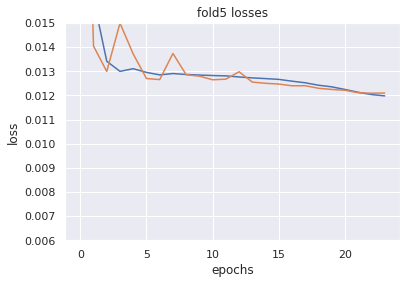

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65618, train_metric: 0.65611
valid_loss: 0.30985, valid_metric: 0.30933
-----EPOCH2-----
train_loss: 0.06799, train_metric: 0.06622
valid_loss: 0.02274, valid_metric: 0.02029
-----EPOCH3-----
train_loss: 0.02116, train_metric: 0.01845
valid_loss: 0.02035, valid_metric: 0.01748
-----EPOCH4-----
train_loss: 0.02005, train_metric: 0.01708
valid_loss: 0.02006, valid_metric: 0.01703
-----EPOCH5-----
train_loss: 0.02664, train_metric: 0.02352
valid_loss: 0.02018, valid_metric: 0.01695
-----EPOCH6-----
train_loss: 0.01975, train_metric: 0.01655
valid_loss: 0.02005, valid_metric: 0.01678
-----EPOCH7-----
train_loss: 0.01951, train_metric: 0.01628
valid_loss: 0.01992, valid_metric: 0.01668
-----EPOCH8-----
train_loss: 0.01946, train_metric: 0.01622
valid_loss: 0.01991, valid_metric: 0.01663
-----EPOCH9-----
train_loss: 0.01963, train_metric: 0.01639
valid_loss: 0.01993, valid_metric: 0.01667
-----EPOCH10-----
train_loss: 0.01937, train_metric: 0.01

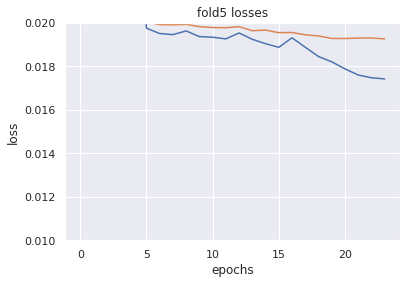

 
SEED : 8

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50887, train_metric: 0.50844
valid_loss: 0.02452, valid_metric: 0.02221
-----EPOCH2-----
train_loss: 0.01581, train_metric: 0.01298
valid_loss: 0.01429, valid_metric: 0.01119
-----EPOCH3-----
train_loss: 0.01379, train_metric: 0.01051
valid_loss: 0.01298, valid_metric: 0.00961
-----EPOCH4-----
train_loss: 0.01302, train_metric: 0.00969
valid_loss: 0.01273, valid_metric: 0.00943
-----EPOCH5-----
train_loss: 0.01302, train_metric: 0.00972
valid_loss: 0.01299, valid_metric: 0.00967
-----EPOCH6-----
train_loss: 0.01284, train_metric: 0.00956
valid_loss: 0.01278, valid_metric: 0.00952
-----EPOCH7-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01280, valid_metric: 0.00954
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01277, valid_metric: 0.00952
-----EPOCH9-----
train_loss: 0.01288, train_metric: 0.00963
valid_loss: 0.01304, valid_metric: 0.00975
-----EPOCH10-----
t

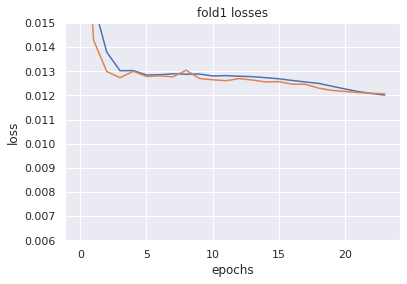

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65127, train_metric: 0.65120
valid_loss: 0.31452, valid_metric: 0.31401
-----EPOCH2-----
train_loss: 0.06804, train_metric: 0.06627
valid_loss: 0.02280, valid_metric: 0.02035
-----EPOCH3-----
train_loss: 0.02124, train_metric: 0.01853
valid_loss: 0.02037, valid_metric: 0.01751
-----EPOCH4-----
train_loss: 0.02010, train_metric: 0.01712
valid_loss: 0.02005, valid_metric: 0.01701
-----EPOCH5-----
train_loss: 0.02308, train_metric: 0.01990
valid_loss: 0.02004, valid_metric: 0.01677
-----EPOCH6-----
train_loss: 0.01984, train_metric: 0.01663
valid_loss: 0.01987, valid_metric: 0.01662
-----EPOCH7-----
train_loss: 0.01966, train_metric: 0.01644
valid_loss: 0.01987, valid_metric: 0.01657
-----EPOCH8-----
train_loss: 0.01959, train_metric: 0.01636
valid_loss: 0.01978, valid_metric: 0.01650
-----EPOCH9-----
train_loss: 0.01985, train_metric: 0.01661
valid_loss: 0.01981, valid_metric: 0.01655
-----EPOCH10-----
train_loss: 0.01967, train_metric: 0.01

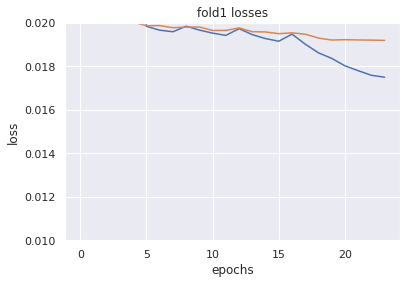

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50769, train_metric: 0.50726
valid_loss: 0.02413, valid_metric: 0.02163
-----EPOCH2-----
train_loss: 0.01588, train_metric: 0.01304
valid_loss: 0.01400, valid_metric: 0.01088
-----EPOCH3-----
train_loss: 0.01339, train_metric: 0.01016
valid_loss: 0.01532, valid_metric: 0.01209
-----EPOCH4-----
train_loss: 0.01313, train_metric: 0.00983
valid_loss: 0.01290, valid_metric: 0.00966
-----EPOCH5-----
train_loss: 0.01347, train_metric: 0.01011
valid_loss: 0.01357, valid_metric: 0.01016
-----EPOCH6-----
train_loss: 0.01326, train_metric: 0.00986
valid_loss: 0.01328, valid_metric: 0.00994
-----EPOCH7-----
train_loss: 0.01288, train_metric: 0.00958
valid_loss: 0.01307, valid_metric: 0.00980
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01279, valid_metric: 0.00956
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00959
valid_loss: 0.01297, valid_metric: 0.00971
-----EPOCH10-----
train_loss: 0

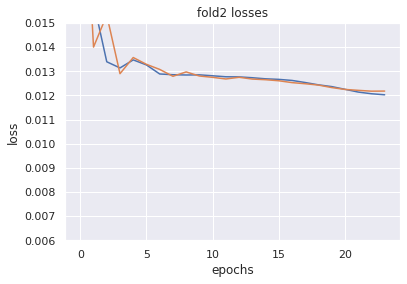

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65234, train_metric: 0.65227
valid_loss: 0.30778, valid_metric: 0.30726
-----EPOCH2-----
train_loss: 0.06768, train_metric: 0.06590
valid_loss: 0.02250, valid_metric: 0.02004
-----EPOCH3-----
train_loss: 0.02125, train_metric: 0.01855
valid_loss: 0.02022, valid_metric: 0.01734
-----EPOCH4-----
train_loss: 0.02011, train_metric: 0.01714
valid_loss: 0.01990, valid_metric: 0.01687
-----EPOCH5-----
train_loss: 0.02367, train_metric: 0.02051
valid_loss: 0.02007, valid_metric: 0.01677
-----EPOCH6-----
train_loss: 0.01980, train_metric: 0.01660
valid_loss: 0.01978, valid_metric: 0.01650
-----EPOCH7-----
train_loss: 0.01971, train_metric: 0.01649
valid_loss: 0.01972, valid_metric: 0.01645
-----EPOCH8-----
train_loss: 0.01956, train_metric: 0.01633
valid_loss: 0.01976, valid_metric: 0.01645
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01657
valid_loss: 0.01976, valid_metric: 0.01648
-----EPOCH10-----
train_loss: 0.01966, train_metric: 0.01

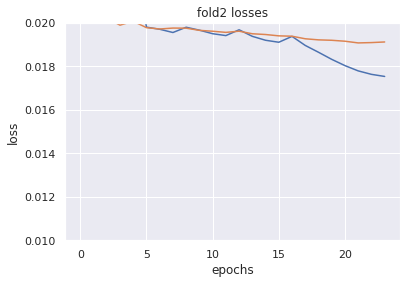

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50884, train_metric: 0.50841
valid_loss: 0.03366, valid_metric: 0.03166
-----EPOCH2-----
train_loss: 0.01627, train_metric: 0.01342
valid_loss: 0.01392, valid_metric: 0.01077
-----EPOCH3-----
train_loss: 0.01342, train_metric: 0.01018
valid_loss: 0.01505, valid_metric: 0.01173
-----EPOCH4-----
train_loss: 0.01328, train_metric: 0.00993
valid_loss: 0.01334, valid_metric: 0.01019
-----EPOCH5-----
train_loss: 0.01299, train_metric: 0.00964
valid_loss: 0.01452, valid_metric: 0.01120
-----EPOCH6-----
train_loss: 0.01310, train_metric: 0.00980
valid_loss: 0.01364, valid_metric: 0.01033
-----EPOCH7-----
train_loss: 0.01301, train_metric: 0.00974
valid_loss: 0.01281, valid_metric: 0.00952
-----EPOCH8-----
train_loss: 0.01289, train_metric: 0.00963
valid_loss: 0.01295, valid_metric: 0.00966
-----EPOCH9-----
train_loss: 0.01289, train_metric: 0.00964
valid_loss: 0.01330, valid_metric: 0.01008
-----EPOCH10-----
train_loss: 0

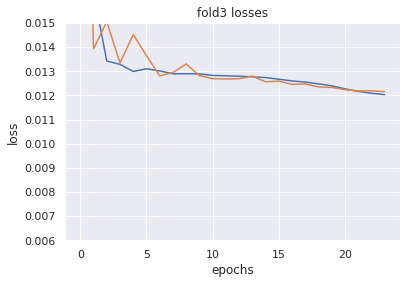

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65103, train_metric: 0.65095
valid_loss: 0.30707, valid_metric: 0.30655
-----EPOCH2-----
train_loss: 0.06807, train_metric: 0.06630
valid_loss: 0.02271, valid_metric: 0.02025
-----EPOCH3-----
train_loss: 0.02132, train_metric: 0.01861
valid_loss: 0.02041, valid_metric: 0.01755
-----EPOCH4-----
train_loss: 0.02016, train_metric: 0.01719
valid_loss: 0.02011, valid_metric: 0.01709
-----EPOCH5-----
train_loss: 0.02309, train_metric: 0.01995
valid_loss: 0.02010, valid_metric: 0.01685
-----EPOCH6-----
train_loss: 0.01992, train_metric: 0.01672
valid_loss: 0.02007, valid_metric: 0.01678
-----EPOCH7-----
train_loss: 0.01977, train_metric: 0.01655
valid_loss: 0.01991, valid_metric: 0.01665
-----EPOCH8-----
train_loss: 0.01968, train_metric: 0.01646
valid_loss: 0.01994, valid_metric: 0.01666
-----EPOCH9-----
train_loss: 0.01996, train_metric: 0.01673
valid_loss: 0.02003, valid_metric: 0.01682
-----EPOCH10-----
train_loss: 0.01963, train_metric: 0.01

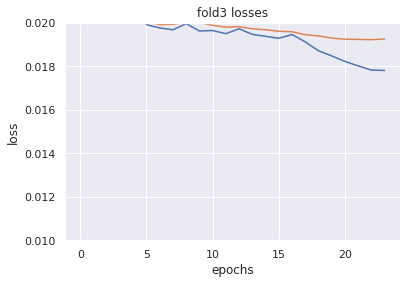

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50822, train_metric: 0.50778
valid_loss: 0.02441, valid_metric: 0.02203
-----EPOCH2-----
train_loss: 0.01586, train_metric: 0.01303
valid_loss: 0.01423, valid_metric: 0.01113
-----EPOCH3-----
train_loss: 0.01354, train_metric: 0.01033
valid_loss: 0.01290, valid_metric: 0.00971
-----EPOCH4-----
train_loss: 0.01301, train_metric: 0.00972
valid_loss: 0.01276, valid_metric: 0.00950
-----EPOCH5-----
train_loss: 0.01311, train_metric: 0.00979
valid_loss: 0.01292, valid_metric: 0.00965
-----EPOCH6-----
train_loss: 0.01305, train_metric: 0.00971
valid_loss: 0.01264, valid_metric: 0.00931
-----EPOCH7-----
train_loss: 0.01286, train_metric: 0.00958
valid_loss: 0.01272, valid_metric: 0.00946
-----EPOCH8-----
train_loss: 0.01283, train_metric: 0.00958
valid_loss: 0.01426, valid_metric: 0.01097
-----EPOCH9-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01266, valid_metric: 0.00939
-----EPOCH10-----
train_loss: 0

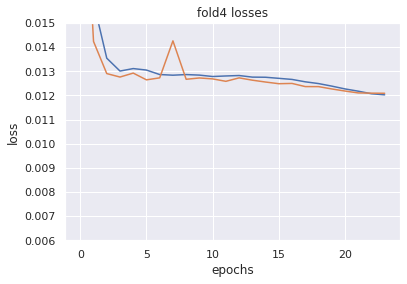

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65004, train_metric: 0.64996
valid_loss: 0.30386, valid_metric: 0.30333
-----EPOCH2-----
train_loss: 0.06716, train_metric: 0.06538
valid_loss: 0.02258, valid_metric: 0.02011
-----EPOCH3-----
train_loss: 0.02124, train_metric: 0.01853
valid_loss: 0.02024, valid_metric: 0.01737
-----EPOCH4-----
train_loss: 0.02005, train_metric: 0.01708
valid_loss: 0.01994, valid_metric: 0.01691
-----EPOCH5-----
train_loss: 0.02286, train_metric: 0.01970
valid_loss: 0.01999, valid_metric: 0.01672
-----EPOCH6-----
train_loss: 0.01983, train_metric: 0.01662
valid_loss: 0.01997, valid_metric: 0.01677
-----EPOCH7-----
train_loss: 0.01971, train_metric: 0.01649
valid_loss: 0.01980, valid_metric: 0.01655
-----EPOCH8-----
train_loss: 0.01963, train_metric: 0.01640
valid_loss: 0.01975, valid_metric: 0.01650
-----EPOCH9-----
train_loss: 0.01974, train_metric: 0.01651
valid_loss: 0.01992, valid_metric: 0.01665
-----EPOCH10-----
train_loss: 0.01952, train_metric: 0.01

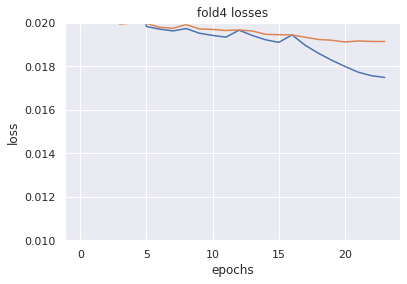

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50866, train_metric: 0.50823
valid_loss: 0.02725, valid_metric: 0.02510
-----EPOCH2-----
train_loss: 0.01584, train_metric: 0.01302
valid_loss: 0.01371, valid_metric: 0.01066
-----EPOCH3-----
train_loss: 0.01412, train_metric: 0.01085
valid_loss: 0.01315, valid_metric: 0.00979
-----EPOCH4-----
train_loss: 0.01337, train_metric: 0.00994
valid_loss: 0.01272, valid_metric: 0.00940
-----EPOCH5-----
train_loss: 0.01296, train_metric: 0.00963
valid_loss: 0.01271, valid_metric: 0.00943
-----EPOCH6-----
train_loss: 0.01294, train_metric: 0.00965
valid_loss: 0.01287, valid_metric: 0.00961
-----EPOCH7-----
train_loss: 0.01295, train_metric: 0.00967
valid_loss: 0.01428, valid_metric: 0.01104
-----EPOCH8-----
train_loss: 0.01300, train_metric: 0.00975
valid_loss: 0.01322, valid_metric: 0.00999
-----EPOCH9-----
train_loss: 0.01293, train_metric: 0.00968
valid_loss: 0.01272, valid_metric: 0.00954
-----EPOCH10-----
train_loss: 0

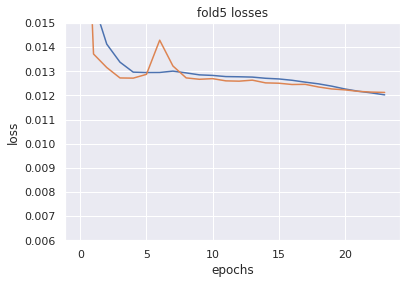

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65134, train_metric: 0.65126
valid_loss: 0.30704, valid_metric: 0.30652
-----EPOCH2-----
train_loss: 0.06791, train_metric: 0.06614
valid_loss: 0.02293, valid_metric: 0.02048
-----EPOCH3-----
train_loss: 0.02124, train_metric: 0.01853
valid_loss: 0.02054, valid_metric: 0.01768
-----EPOCH4-----
train_loss: 0.02013, train_metric: 0.01716
valid_loss: 0.02013, valid_metric: 0.01711
-----EPOCH5-----
train_loss: 0.02369, train_metric: 0.02051
valid_loss: 0.02032, valid_metric: 0.01700
-----EPOCH6-----
train_loss: 0.01983, train_metric: 0.01661
valid_loss: 0.02010, valid_metric: 0.01673
-----EPOCH7-----
train_loss: 0.01970, train_metric: 0.01647
valid_loss: 0.02005, valid_metric: 0.01681
-----EPOCH8-----
train_loss: 0.01958, train_metric: 0.01634
valid_loss: 0.02000, valid_metric: 0.01679
-----EPOCH9-----
train_loss: 0.01984, train_metric: 0.01661
valid_loss: 0.02014, valid_metric: 0.01682
-----EPOCH10-----
train_loss: 0.01957, train_metric: 0.01

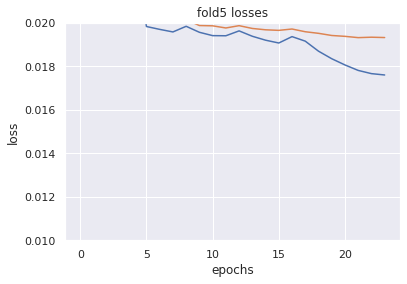

 
SEED : 9

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50808, train_metric: 0.50765
valid_loss: 0.02507, valid_metric: 0.02283
-----EPOCH2-----
train_loss: 0.01577, train_metric: 0.01294
valid_loss: 0.01427, valid_metric: 0.01114
-----EPOCH3-----
train_loss: 0.01353, train_metric: 0.01031
valid_loss: 0.01332, valid_metric: 0.01008
-----EPOCH4-----
train_loss: 0.01382, train_metric: 0.01037
valid_loss: 0.01350, valid_metric: 0.01021
-----EPOCH5-----
train_loss: 0.01300, train_metric: 0.00967
valid_loss: 0.01344, valid_metric: 0.01012
-----EPOCH6-----
train_loss: 0.01292, train_metric: 0.00963
valid_loss: 0.01278, valid_metric: 0.00952
-----EPOCH7-----
train_loss: 0.01287, train_metric: 0.00961
valid_loss: 0.01284, valid_metric: 0.00962
-----EPOCH8-----
train_loss: 0.01287, train_metric: 0.00962
valid_loss: 0.01273, valid_metric: 0.00947
-----EPOCH9-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01280, valid_metric: 0.00953
-----EPOCH10-----
t

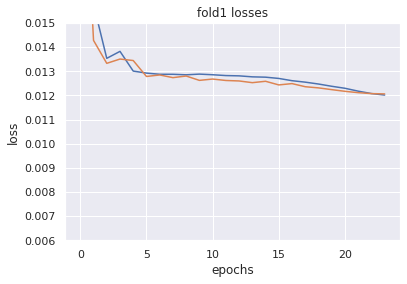

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65316, train_metric: 0.65308
valid_loss: 0.30720, valid_metric: 0.30668
-----EPOCH2-----
train_loss: 0.06734, train_metric: 0.06557
valid_loss: 0.02254, valid_metric: 0.02008
-----EPOCH3-----
train_loss: 0.02117, train_metric: 0.01846
valid_loss: 0.02026, valid_metric: 0.01739
-----EPOCH4-----
train_loss: 0.02008, train_metric: 0.01710
valid_loss: 0.02001, valid_metric: 0.01698
-----EPOCH5-----
train_loss: 0.02314, train_metric: 0.01994
valid_loss: 0.02008, valid_metric: 0.01680
-----EPOCH6-----
train_loss: 0.01989, train_metric: 0.01666
valid_loss: 0.02004, valid_metric: 0.01671
-----EPOCH7-----
train_loss: 0.01966, train_metric: 0.01643
valid_loss: 0.01986, valid_metric: 0.01659
-----EPOCH8-----
train_loss: 0.01962, train_metric: 0.01638
valid_loss: 0.01982, valid_metric: 0.01654
-----EPOCH9-----
train_loss: 0.01989, train_metric: 0.01665
valid_loss: 0.01999, valid_metric: 0.01663
-----EPOCH10-----
train_loss: 0.01965, train_metric: 0.01

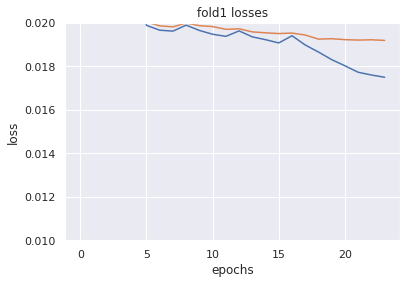

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50806, train_metric: 0.50763
valid_loss: 0.02543, valid_metric: 0.02328
-----EPOCH2-----
train_loss: 0.01649, train_metric: 0.01363
valid_loss: 0.01411, valid_metric: 0.01082
-----EPOCH3-----
train_loss: 0.01337, train_metric: 0.01009
valid_loss: 0.01333, valid_metric: 0.01011
-----EPOCH4-----
train_loss: 0.01310, train_metric: 0.00980
valid_loss: 0.01291, valid_metric: 0.00958
-----EPOCH5-----
train_loss: 0.01290, train_metric: 0.00958
valid_loss: 0.01282, valid_metric: 0.00954
-----EPOCH6-----
train_loss: 0.01293, train_metric: 0.00964
valid_loss: 0.01575, valid_metric: 0.01238
-----EPOCH7-----
train_loss: 0.01293, train_metric: 0.00965
valid_loss: 0.01337, valid_metric: 0.01007
-----EPOCH8-----
train_loss: 0.01281, train_metric: 0.00955
valid_loss: 0.01273, valid_metric: 0.00948
-----EPOCH9-----
train_loss: 0.01279, train_metric: 0.00954
valid_loss: 0.01284, valid_metric: 0.00955
-----EPOCH10-----
train_loss: 0

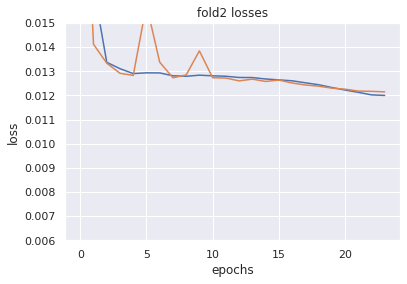

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65484, train_metric: 0.65477
valid_loss: 0.30955, valid_metric: 0.30903
-----EPOCH2-----
train_loss: 0.06734, train_metric: 0.06556
valid_loss: 0.02258, valid_metric: 0.02013
-----EPOCH3-----
train_loss: 0.02116, train_metric: 0.01845
valid_loss: 0.02021, valid_metric: 0.01732
-----EPOCH4-----
train_loss: 0.01999, train_metric: 0.01702
valid_loss: 0.01985, valid_metric: 0.01684
-----EPOCH5-----
train_loss: 0.02481, train_metric: 0.02169
valid_loss: 0.01988, valid_metric: 0.01662
-----EPOCH6-----
train_loss: 0.01979, train_metric: 0.01658
valid_loss: 0.01975, valid_metric: 0.01649
-----EPOCH7-----
train_loss: 0.01960, train_metric: 0.01636
valid_loss: 0.01968, valid_metric: 0.01642
-----EPOCH8-----
train_loss: 0.01948, train_metric: 0.01624
valid_loss: 0.01971, valid_metric: 0.01640
-----EPOCH9-----
train_loss: 0.01974, train_metric: 0.01649
valid_loss: 0.01976, valid_metric: 0.01651
-----EPOCH10-----
train_loss: 0.01951, train_metric: 0.01

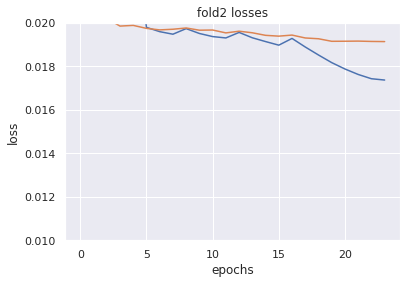

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50924, train_metric: 0.50881
valid_loss: 0.02762, valid_metric: 0.02546
-----EPOCH2-----
train_loss: 0.01605, train_metric: 0.01320
valid_loss: 0.01368, valid_metric: 0.01062
-----EPOCH3-----
train_loss: 0.01341, train_metric: 0.01018
valid_loss: 0.01492, valid_metric: 0.01164
-----EPOCH4-----
train_loss: 0.01306, train_metric: 0.00978
valid_loss: 0.01553, valid_metric: 0.01226
-----EPOCH5-----
train_loss: 0.01301, train_metric: 0.00972
valid_loss: 0.01282, valid_metric: 0.00956
-----EPOCH6-----
train_loss: 0.01284, train_metric: 0.00953
valid_loss: 0.01505, valid_metric: 0.01174
-----EPOCH7-----
train_loss: 0.01289, train_metric: 0.00962
valid_loss: 0.01269, valid_metric: 0.00944
-----EPOCH8-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01329, valid_metric: 0.01006
-----EPOCH9-----
train_loss: 0.01287, train_metric: 0.00962
valid_loss: 0.01270, valid_metric: 0.00941
-----EPOCH10-----
train_loss: 0

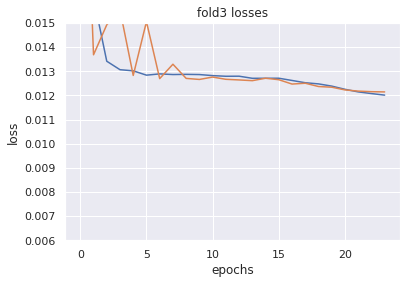

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65095, train_metric: 0.65088
valid_loss: 0.30703, valid_metric: 0.30651
-----EPOCH2-----
train_loss: 0.06672, train_metric: 0.06493
valid_loss: 0.02262, valid_metric: 0.02016
-----EPOCH3-----
train_loss: 0.02112, train_metric: 0.01840
valid_loss: 0.02037, valid_metric: 0.01751
-----EPOCH4-----
train_loss: 0.02005, train_metric: 0.01708
valid_loss: 0.02005, valid_metric: 0.01701
-----EPOCH5-----
train_loss: 0.02525, train_metric: 0.02208
valid_loss: 0.02021, valid_metric: 0.01692
-----EPOCH6-----
train_loss: 0.01979, train_metric: 0.01656
valid_loss: 0.01999, valid_metric: 0.01669
-----EPOCH7-----
train_loss: 0.01968, train_metric: 0.01644
valid_loss: 0.01997, valid_metric: 0.01662
-----EPOCH8-----
train_loss: 0.01952, train_metric: 0.01629
valid_loss: 0.01987, valid_metric: 0.01661
-----EPOCH9-----
train_loss: 0.01973, train_metric: 0.01649
valid_loss: 0.02008, valid_metric: 0.01681
-----EPOCH10-----
train_loss: 0.01953, train_metric: 0.01

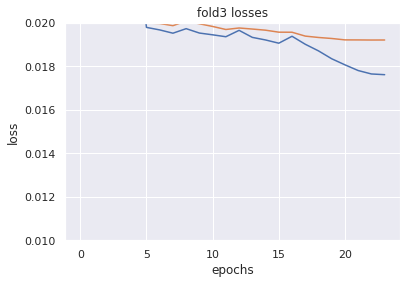

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50801, train_metric: 0.50758
valid_loss: 0.02882, valid_metric: 0.02649
-----EPOCH2-----
train_loss: 0.01605, train_metric: 0.01321
valid_loss: 0.01366, valid_metric: 0.01053
-----EPOCH3-----
train_loss: 0.01358, train_metric: 0.01032
valid_loss: 0.01337, valid_metric: 0.01002
-----EPOCH4-----
train_loss: 0.01304, train_metric: 0.00970
valid_loss: 0.01349, valid_metric: 0.01018
-----EPOCH5-----
train_loss: 0.01292, train_metric: 0.00962
valid_loss: 0.01269, valid_metric: 0.00941
-----EPOCH6-----
train_loss: 0.01298, train_metric: 0.00967
valid_loss: 0.01286, valid_metric: 0.00951
-----EPOCH7-----
train_loss: 0.01289, train_metric: 0.00962
valid_loss: 0.01447, valid_metric: 0.01121
-----EPOCH8-----
train_loss: 0.01299, train_metric: 0.00973
valid_loss: 0.01292, valid_metric: 0.00968
-----EPOCH9-----
train_loss: 0.01286, train_metric: 0.00961
valid_loss: 0.01268, valid_metric: 0.00942
-----EPOCH10-----
train_loss: 0

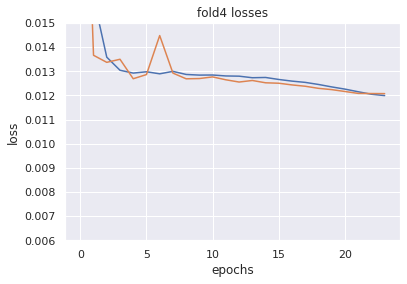

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65267, train_metric: 0.65260
valid_loss: 0.30934, valid_metric: 0.30882
-----EPOCH2-----
train_loss: 0.06698, train_metric: 0.06520
valid_loss: 0.02262, valid_metric: 0.02018
-----EPOCH3-----
train_loss: 0.02111, train_metric: 0.01840
valid_loss: 0.02024, valid_metric: 0.01737
-----EPOCH4-----
train_loss: 0.02005, train_metric: 0.01708
valid_loss: 0.01987, valid_metric: 0.01685
-----EPOCH5-----
train_loss: 0.02387, train_metric: 0.02071
valid_loss: 0.01995, valid_metric: 0.01660
-----EPOCH6-----
train_loss: 0.01986, train_metric: 0.01664
valid_loss: 0.01989, valid_metric: 0.01665
-----EPOCH7-----
train_loss: 0.01964, train_metric: 0.01641
valid_loss: 0.01971, valid_metric: 0.01647
-----EPOCH8-----
train_loss: 0.01950, train_metric: 0.01627
valid_loss: 0.01973, valid_metric: 0.01648
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01656
valid_loss: 0.01991, valid_metric: 0.01669
-----EPOCH10-----
train_loss: 0.01953, train_metric: 0.01

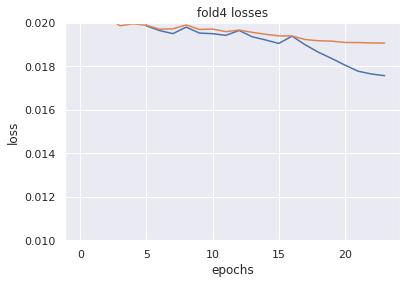

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50787, train_metric: 0.50743
valid_loss: 0.03551, valid_metric: 0.03346
-----EPOCH2-----
train_loss: 0.01593, train_metric: 0.01309
valid_loss: 0.01358, valid_metric: 0.01041
-----EPOCH3-----
train_loss: 0.01336, train_metric: 0.01012
valid_loss: 0.01290, valid_metric: 0.00964
-----EPOCH4-----
train_loss: 0.01308, train_metric: 0.00979
valid_loss: 0.01482, valid_metric: 0.01156
-----EPOCH5-----
train_loss: 0.01292, train_metric: 0.00962
valid_loss: 0.01295, valid_metric: 0.00968
-----EPOCH6-----
train_loss: 0.01289, train_metric: 0.00961
valid_loss: 0.01337, valid_metric: 0.01013
-----EPOCH7-----
train_loss: 0.01287, train_metric: 0.00960
valid_loss: 0.01268, valid_metric: 0.00941
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01271, valid_metric: 0.00947
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00959
valid_loss: 0.01269, valid_metric: 0.00946
-----EPOCH10-----
train_loss: 0

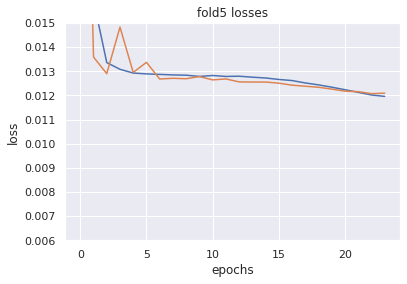

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65112, train_metric: 0.65105
valid_loss: 0.30249, valid_metric: 0.30196
-----EPOCH2-----
train_loss: 0.06647, train_metric: 0.06469
valid_loss: 0.02263, valid_metric: 0.02017
-----EPOCH3-----
train_loss: 0.02102, train_metric: 0.01831
valid_loss: 0.02035, valid_metric: 0.01748
-----EPOCH4-----
train_loss: 0.01996, train_metric: 0.01699
valid_loss: 0.02006, valid_metric: 0.01702
-----EPOCH5-----
train_loss: 0.02626, train_metric: 0.02314
valid_loss: 0.02024, valid_metric: 0.01694
-----EPOCH6-----
train_loss: 0.01968, train_metric: 0.01648
valid_loss: 0.02007, valid_metric: 0.01677
-----EPOCH7-----
train_loss: 0.01951, train_metric: 0.01628
valid_loss: 0.01999, valid_metric: 0.01671
-----EPOCH8-----
train_loss: 0.01941, train_metric: 0.01617
valid_loss: 0.01998, valid_metric: 0.01668
-----EPOCH9-----
train_loss: 0.01960, train_metric: 0.01635
valid_loss: 0.02010, valid_metric: 0.01689
-----EPOCH10-----
train_loss: 0.01946, train_metric: 0.01

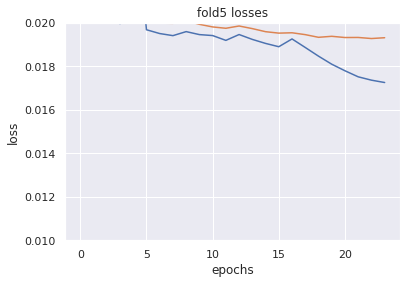

In [36]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

print(f'device used: {DEVICE}')

for seed in SEED:
    
    print(f' ')
    print(f'SEED : {seed}')
    print(f'')
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed, EPOCHS, LEARNING_RATE)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)
    
train[target_cols] = oof
test[target_cols] = predictions

In [37]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(
    train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

cv = 0
for i in range(len(target_cols)):
    cv_ = log_loss(y_true[:, i], y_pred[:, i])
    cv += cv_ / len(target_cols)
    
auc = 0
for i in range(len(target_cols)):
    auc_ = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc += auc_ / len(target_cols)
    
print(f'CV log_loss: {cv:.6f}')
print(f'AUC: {auc:.6f}')

CV log_loss: 0.014693
AUC: 0.813674


In [38]:
file_path = 'oof_Simple_Deep.npy'
np.save(file_path, y_pred)

sub = sample_submission.drop(columns=target_cols).merge(
    test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [39]:
print(f'sample_submission.shape : {sample_submission.shape}')
print(f'sub.shape : {sub.shape}')

sample_submission.shape : (3982, 207)
sub.shape : (3982, 207)
